In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from bisect import bisect_left
import statsmodels.api as sm
import glob
import scipy
import itertools
from scipy.special import binom
from scipy.stats import skew
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
import itertools
from matplotlib.lines import Line2D



From the paper:

"Because we are using relative fitness, the effect of each individual drug can be interpreted as a percent reduction in growth rate, so the null expectation for the combined effects of two non-interacting drugs would be the product of two percentages, corresponding to a multiplicative definition of no interaction."


These data files are organized by plate in which E. coli was exposed to all combinations of 5 drugs. 

Since 8 drugs were tested in total, there are binom(8,5)=56 plates. Thus, some drug combinations are redundant across plates.

Thus, for a specific concentration (e.g. only concentration == 1) 
- each single drug is represented binom(7,4) = 35 times
- each drug pair binom(6,3) = 20 times
- each drug triple binom(5,2) = 10 times
- each drug quadruple binom(4,1) = 4 times

In [3]:
Lozano_2021_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/drug_data/Lozano-HuntelmanEtAl2021/Raw Data and Growth Rate/Interaction Calculation/Data/Data/output_29-Oct-2020_log data/publish data_log"
# within directory cloned from git repo:
# Lozano_2021_data_dir = "epistasis_reanalysis/drug_data/Lozano-HuntelmanEtAl2021/Raw Data and Growth Rate/Interaction Calculation/Data/Data/output_29-Oct-2020_log data/publish data_log"

# files from this path were selected because of the contents of:
# drug_data/Lozano-HuntelmanEtAl2021/Raw Data and Growth Rate/Interaction Calculation/AnalysisSetup.m

# read all data files and combine into one data table

files = glob.glob(Lozano_2021_data_dir + "/*.csv")
df = pd.DataFrame
for f in files:
    tmp = pd.read_csv(f, sep=",")
    tmp = tmp.loc[:, "combinations":"X1X2X3X4X5"]
    try:
        df = pd.concat([df, tmp], axis=0)
    except:
        df = tmp
df = df.reset_index(drop=True)


In [4]:
# use this to select particular drug concentrations, use '~' to exclude certain concentrations
df = df[(df.combinations.str.contains("1")) & 
    (df.combinations.str.contains("2")) &
    (df.combinations.str.contains("3"))]

In [5]:
df.head()

,combinations,X1,X2,X3,X4,X5,X1X2,X1X3,X1X4,X1X5,...,X2X3X4,X2X3X5,X2X4X5,X3X4X5,X1X2X3X4,X1X2X3X5,X1X2X4X5,X1X3X4X5,X2X3X4X5,X1X2X3X4X5
5,AMP1FOX1FUS1CPR2ERY3,0.96503,0.99944,0.60245,1.0,1.0,0.62984,0.47301,0.94507,0.96706,...,0.46157,0.58936,0.98654,0.68567,0.064393,0.53402,0.73076,0.60179,0.54037,0.42522
7,AMP1FOX1FUS1CPR3ERY2,0.96503,0.99944,0.60245,1.0,1.0,0.62984,0.47301,0.96906,0.96402,...,0.49614,0.80682,0.89645,0.70443,0.422080,0.44888,0.52307,0.48124,0.68634,0.44465
11,AMP1FOX1FUS2CPR1ERY3,0.96503,0.99944,0.72911,1.0,1.0,0.62984,0.62375,0.84633,0.96706,...,0.43195,0.59156,0.97794,0.38201,0.440450,0.37552,0.75830,0.66242,0.64627,0.63737
14,AMP1FOX1FUS2CPR2ERY3,0.96503,0.99944,0.72911,1.0,1.0,0.62984,0.62375,0.94507,0.96706,...,0.66037,0.59156,0.98654,0.70407,0.621110,0.37552,0.73076,0.51733,0.66517,0.38721
15,AMP1FOX1FUS2CPR3ERY1,0.96503,0.99944,0.72911,1.0,1.0,0.62984,0.62375,0.96906,0.97794,...,0.73081,0.65211,0.98384,0.80204,0.460100,0.47294,0.84764,0.63379,0.73076,0.48800


In [6]:
# split data table by drug combination order for downstream analyses

df_sing = df.loc[:,"X1":"X5"].reset_index(drop=True)
df_doub = df.loc[:,"X1X2":"X4X5"].reset_index(drop=True)
df_trip = df.loc[:,"X1X2X3":"X3X4X5"].reset_index(drop=True)
df_quad = df.loc[:,"X1X2X3X4":"X2X3X4X5"].reset_index(drop=True)
df_quin = pd.DataFrame(df.loc[:,"X1X2X3X4X5"].reset_index(drop=True))
combinations = pd.DataFrame(df.loc[:,"combinations"].reset_index(drop=True))

# one of the columns has an extra whitespace
df_trip = df_trip.rename(columns={'X1X4X5 ' : 'X1X4X5'})

# NOTE: To quantify interactions below, you will need to access fitnesses for all lower order drug combinations. 
# The names of columns across these data tables indicate how to access lower order drug fitnesses, 
# as the numbers in the columns indicate which of the 5 drugs (stored in the "combinations" df). E.g.
# for 3-drug combo X2X3X4 in df_trip, the lower order 2-drug combos in df_doub would be X2X3, X2X4, X3X4, 
# and the 1-drug combos would be X2, X3, X4 in df_sing. 


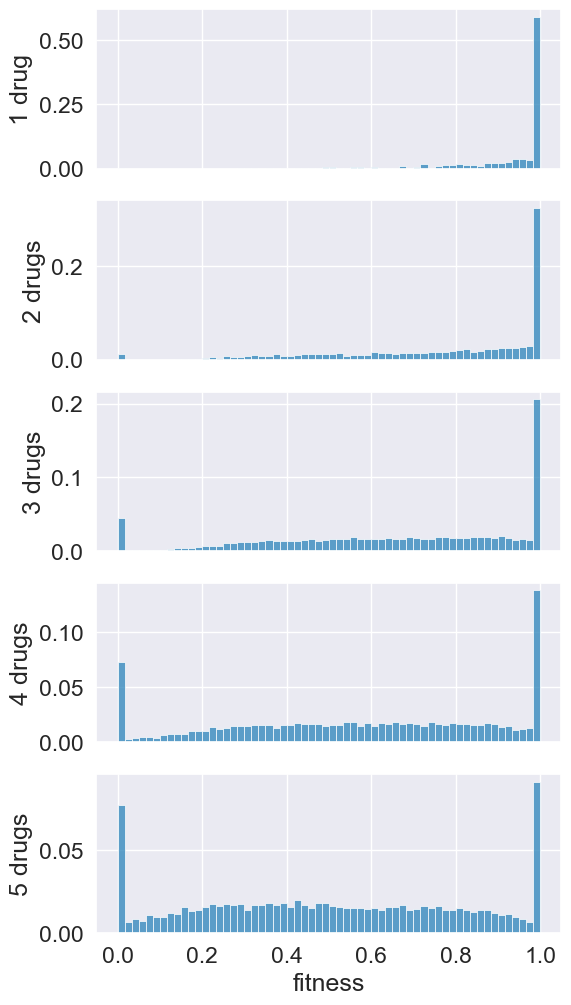

In [7]:
# what do the fitness distributions look like for each drug combination order?

sns.set(font_scale = 1.5)
fig, axs = plt.subplots(nrows=5, figsize=(15,5))
fig.set_size_inches(6, 12)
bins=60

def concat_cols(df):
    x = []
    [x.extend(list(df[i])) for i in list(df.columns)]
    return x

def plot_fitness(df, title, index):
    sns.histplot(concat_cols(df),  color="#2b83ba", bins = bins, stat="probability", ax=axs[index])
    if index < 4:
        axs[index].set(xlabel=None, ylabel=title, xticklabels=[])
    else:
        axs[index].set(xlabel="fitness", ylabel=title)

sns.set_style("whitegrid")
plot_fitness(df_sing, "1 drug", 0)
plot_fitness(df_doub, "2 drugs", 1)
plot_fitness(df_trip, "3 drugs", 2)
plot_fitness(df_quad, "4 drugs", 3)
plot_fitness(df_quin, "5 drugs", 4)



In [8]:
def get_fitness_triple_interaction(df_sing, df_doub, df_trip, col):
    """
    split column, or multi-drug combo, into individual single drug labels
    e.g. X1X2X3 becomes [X1, X2, X3]
    each element of list f is one of these single drug labels, 
    use these to get lower-order drug combos
    """
    fitnesses = defaultdict(pd.Series)

    f = [col[i:i+2] for i in range(0, len(col), 2)]

    fitnesses[123] = df_trip[col]

    fitnesses[12] = df_doub[f[0]+f[1]]
    fitnesses[13] = df_doub[f[0]+f[2]]
    fitnesses[23] = df_doub[f[1]+f[2]]

    fitnesses[1] = df_sing[f[0]]
    fitnesses[2] = df_sing[f[1]]
    fitnesses[3] = df_sing[f[2]]

    return fitnesses


def get_fitness_quadruple_interaction(df_sing, df_doub, df_trip, df_quad, col):
    """
    see notes in get_fitness_triple_interaction function
    """

    fitnesses = defaultdict(pd.Series)

    f = [col[i:i+2] for i in range(0, len(col), 2)]

    fitnesses[1234] = df_quad[col]

    fitnesses[123] = df_trip[f[0]+f[1]+f[2]]
    fitnesses[124] = df_trip[f[0]+f[1]+f[3]]
    fitnesses[134] = df_trip[f[0]+f[2]+f[3]]
    fitnesses[234] = df_trip[f[1]+f[2]+f[3]]

    fitnesses[12] = df_doub[f[0]+f[1]]
    fitnesses[13] = df_doub[f[0]+f[2]]
    fitnesses[14] = df_doub[f[0]+f[3]]
    fitnesses[23] = df_doub[f[1]+f[2]]
    fitnesses[24] = df_doub[f[1]+f[3]]
    fitnesses[34] = df_doub[f[2]+f[3]]

    fitnesses[1] = df_sing[f[0]]
    fitnesses[2] = df_sing[f[1]]
    fitnesses[3] = df_sing[f[2]]
    fitnesses[4] = df_sing[f[3]]
    
    return fitnesses


def get_fitness_quintuple_interaction(df_sing, df_doub, df_trip, df_quad, df_quin, col):
    """
    see notes in get_fitness_triple_interaction function
    """
        
    fitnesses = defaultdict(pd.Series)

    f = [col[i:i+2] for i in range(0, len(col), 2)]

    fitnesses[12345] = df_quin[col]

    fitnesses[1234] = df_quad[f[0]+f[1]+f[2]+f[3]]
    fitnesses[1235] = df_quad[f[0]+f[1]+f[2]+f[4]]
    fitnesses[1245] = df_quad[f[0]+f[1]+f[3]+f[4]]
    fitnesses[1345] = df_quad[f[0]+f[2]+f[3]+f[4]]
    fitnesses[2345] = df_quad[f[1]+f[2]+f[3]+f[4]]

    fitnesses[123] = df_trip[f[0]+f[1]+f[2]]
    fitnesses[124] = df_trip[f[0]+f[1]+f[3]]
    fitnesses[125] = df_trip[f[0]+f[1]+f[4]]
    fitnesses[134] = df_trip[f[0]+f[2]+f[3]]
    fitnesses[135] = df_trip[f[0]+f[2]+f[4]]
    fitnesses[145] = df_trip[f[0]+f[3]+f[4]]
    fitnesses[234] = df_trip[f[1]+f[2]+f[3]]
    fitnesses[235] = df_trip[f[1]+f[2]+f[4]]
    fitnesses[245] = df_trip[f[1]+f[3]+f[4]]
    fitnesses[345] = df_trip[f[2]+f[3]+f[4]]

    fitnesses[12] = df_doub[f[0]+f[1]]
    fitnesses[13] = df_doub[f[0]+f[2]]
    fitnesses[14] = df_doub[f[0]+f[3]]
    fitnesses[15] = df_doub[f[0]+f[4]]
    fitnesses[23] = df_doub[f[1]+f[2]]
    fitnesses[24] = df_doub[f[1]+f[3]]
    fitnesses[25] = df_doub[f[1]+f[4]]
    fitnesses[34] = df_doub[f[2]+f[3]]
    fitnesses[35] = df_doub[f[2]+f[4]]
    fitnesses[45] = df_doub[f[3]+f[4]]

    fitnesses[1] = df_sing[f[0]]
    fitnesses[2] = df_sing[f[1]]
    fitnesses[3] = df_sing[f[2]]
    fitnesses[4] = df_sing[f[3]]
    fitnesses[5] = df_sing[f[4]]

    return fitnesses

In [9]:
for col in df_doub.columns:
    f = [col[i:i+2] for i in range(0, len(col), 2)]
    name = col + "_iss"
    df_doub.loc[:, name] = df_doub[col] - (df_sing[f[0]]*df_sing[f[1]])
    name = col + "_ad"
    df_doub.loc[:, name] = df_doub[col] - df_sing[f[0]] - df_sing[f[1]] + 1

for col in df_trip.columns:
    f = get_fitness_triple_interaction(df_sing, df_doub, df_trip, col)
    name = col + "_iss"
    df_trip.loc[:, name] = f[123] + 2*f[1]*f[2]*f[3] - f[12]*f[3] - f[13]*f[2] - f[23]*f[1]
    name = col + "_ad"
    df_trip.loc[:, name] = (f[123]+f[1]+f[2]+f[3]) - (f[12]+f[13]+f[23]) - 1

for col in df_quad.columns:
    f = get_fitness_quadruple_interaction(df_sing, df_doub, df_trip, df_quad, col)
    name = col + "_iss"
    df_quad.loc[:, name] = f[1234] - f[1]*f[234] - f[2]*f[134] - f[3]*f[124] - f[4]*f[123] - f[12]*f[34] - f[13]*f[24] - f[14]*f[23] + (2*f[1]*f[2]*f[34]) + (2*f[1]*f[3]*f[24]) + (2*f[1]*f[4]*f[23]) + (2*f[2]*f[3]*f[14]) + (2*f[2]*f[4]*f[13]) + (2*f[3]*f[4]*f[12]) - (6*f[1]*f[2]*f[3]*f[4])
    name = col + "_ad"
    df_quad.loc[:, name] = (f[1234]+f[12]+f[13]+f[14]+f[23]+f[24]+f[34]) - (f[1]+f[2]+f[3]+f[4]+f[123]+f[124]+f[134]+f[234]) + 1

for col in df_quin.columns:
    f = get_fitness_quintuple_interaction(df_sing, df_doub, df_trip, df_quad, df_quin, col)
    name = col + "_iss"
    # 52 terms
    df_quin.loc[:, name] = f[12345] - 1*f[1]*f[2345] - f[2]*f[1345] - f[3]*f[1245] - f[4]*f[1235] - f[5]*f[1234] - 1*f[12]*f[345] - f[13]*f[245] - f[14]*f[235] - f[15]*f[234] - f[23]*f[145] - f[24]*f[135] - f[25]*f[134] - f[34]*f[125] - f[35]*f[124] - f[45]*f[123] + 2*f[1]*f[2]*f[345] + 2*f[1]*f[3]*f[245] + 2*f[1]*f[4]*f[235] + 2*f[1]*f[5]*f[234] + 2*f[2]*f[3]*f[145] + 2*f[2]*f[4]*f[135] + 2*f[2]*f[5]*f[134] + 2*f[3]*f[4]*f[125] + 2*f[3]*f[5]*f[124] + 2*f[4]*f[5]*f[123] + 2*f[12]*f[34]*f[5] + 2*f[12]*f[35]*f[4] + 2*f[12]*f[45]*f[3] + 2*f[13]*f[24]*f[5] + 2*f[13]*f[25]*f[4] + 2*f[13]*f[45]*f[2] + 2*f[14]*f[23]*f[5] + 2*f[14]*f[25]*f[3] + 2*f[14]*f[35]*f[2] + 2*f[15]*f[23]*f[4] + 2*f[15]*f[24]*f[3] + 2*f[15]*f[34]*f[2] + 2*f[23]*f[45]*f[1] + 2*f[24]*f[35]*f[1] + 2*f[25]*f[34]*f[1] - 6*f[12]*f[3]*f[4]*f[5] - 6*f[13]*f[2]*f[4]*f[5] - 6*f[14]*f[2]*f[3]*f[5] - 6*f[15]*f[2]*f[3]*f[4] - 6*f[23]*f[1]*f[4]*f[5] - 6*f[24]*f[1]*f[3]*f[5] - 6*f[25]*f[1]*f[3]*f[4] - 6*f[34]*f[1]*f[2]*f[5] - 6*f[35]*f[1]*f[2]*f[4] - 6*f[45]*f[1]*f[2]*f[3] + 24*f[1]*f[2]*f[3]*f[4]*f[5]
    name = col + "_ad"
    df_quin.loc[:, name] = (f[12345]+f[1]+f[2]+f[3]+f[4]+f[5]+f[123]+f[124]+f[125]+f[134]+f[135]+f[145]+f[234]+f[235]+f[245]+f[345]) - (f[12]+f[13]+f[14]+f[15]+f[23]+f[24]+f[25]+f[34]+f[35]+f[45]+f[1234]+f[1235]+f[1245]+f[1345]+f[2345]) -1


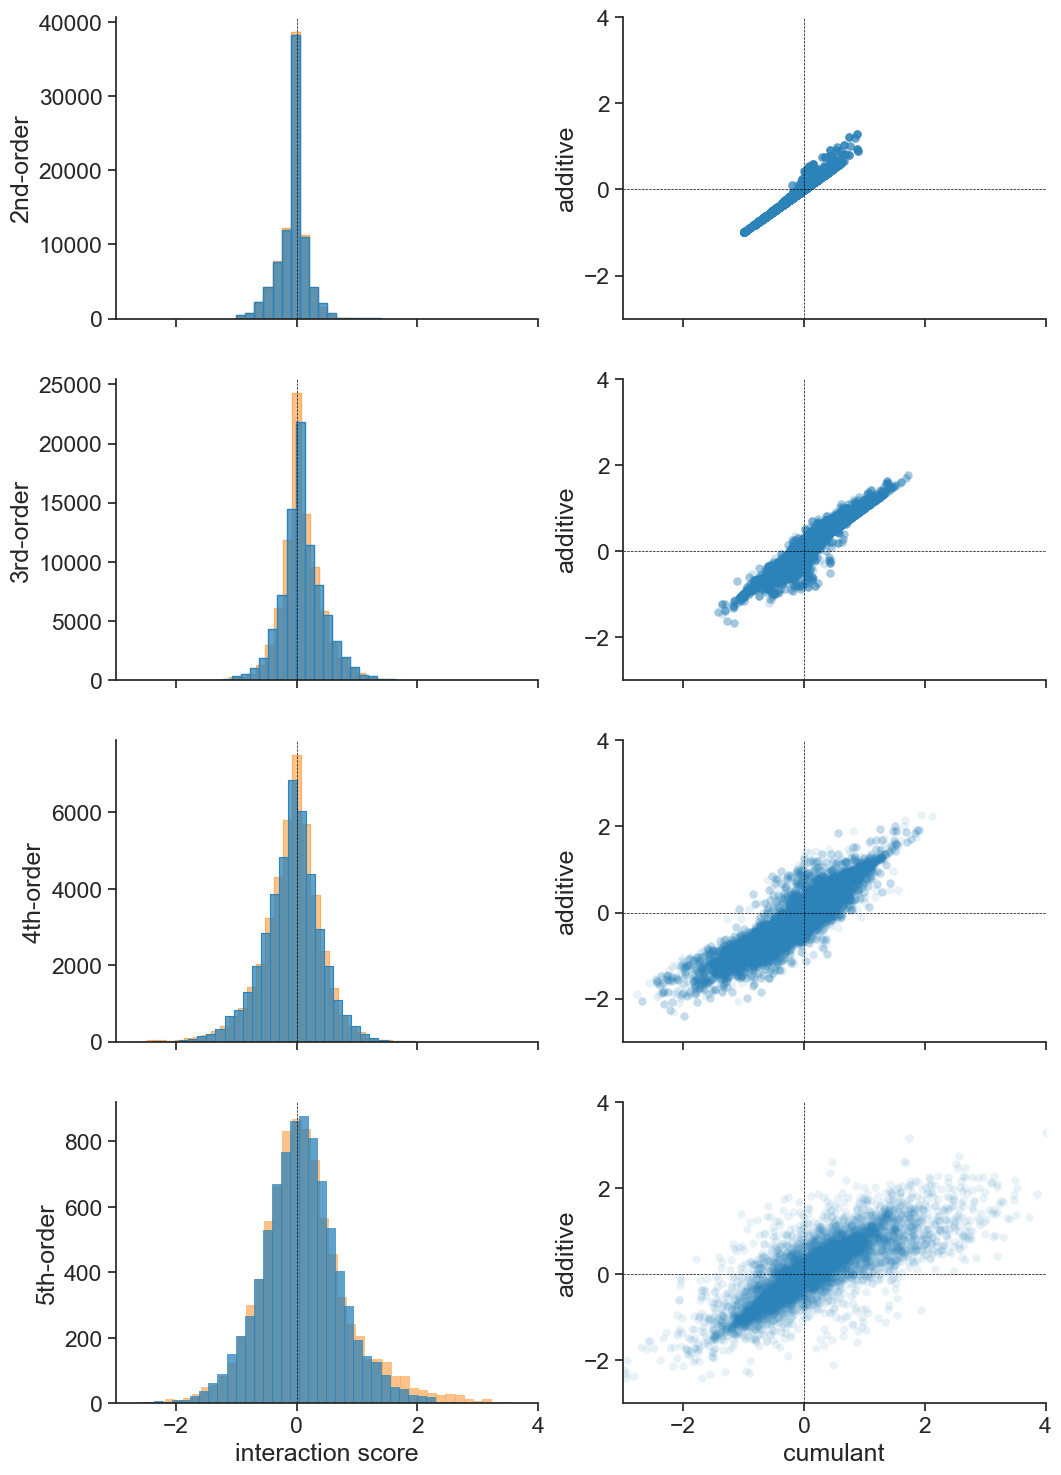

In [10]:
def get_noninf(df):
    x = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    y = np.array(concat_cols(df.filter(regex=(".*_ad"))))
    x = x[~np.isnan(y) & np.isfinite(y)]
    y = y[~np.isnan(y) & np.isfinite(y)]
    return x, y

def mk_histplot(df, pl, title, row):
    sns.histplot(concat_cols(df.filter(regex=(".*_iss"))), binwidth=pl['binwid'], color=pl['col_iss'], edgecolor=pl['edgecol_iss'], ax=axs[row,0])
    sns.histplot(concat_cols(df.filter(regex=(".*_ad"))), binwidth=pl['binwid'], color=pl['col_ad'], edgecolor=pl['edgecol_ad'], ax=axs[row,0])
    if row < 3:
        axs[row,0].set(xlabel=None, ylabel=title, xticklabels=[])
    else:
        axs[row,0].set(xlabel="interaction score", ylabel=title)
    axs[row,0].set_xlim(-3,4)
    axs[row,0].axvline(0, color="black", linestyle="--", linewidth=0.5)

    x, y = get_noninf(df)
    sns.scatterplot(x=x, 
                y=y,   
                alpha=pl['transparency'], color=pl['col_ad'], linewidth=0,
                ax=axs[row,1])
    if row < 3:
        axs[row,1].set(xlabel=None, ylabel="additive", xticklabels=[])
    else:
        axs[row,1].set(xlabel="cumulant", ylabel="additive")
    axs[row,1].axvline(0, color="black", linestyle="--", linewidth=0.5)
    axs[row,1].axhline(0, color="black", linestyle="--", linewidth=0.5)
    axs[row,1].set_ylim(-3,4)
    axs[row,1].set_xlim(-3,4)
    #axs[row,1].axline([0,1], [80, 81], linestyle="--", color="black")



sns.set(font_scale = 1.5)
sns.set_style("ticks")
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,5))
fig.set_size_inches(12, 18)

for_plt = {}
for_plt['binwid'] = 0.15
for_plt['transparency']=0.1

# brown and green
#col_iss = "#018571"
#col_mult = "#a6611a"
#edgecol_iss = "#018571"
#edgecol_mult = "#a6611a"

# yellow and blue
#col_iss = "#ffff99"
#col_mult = "#386cb0"
#edgecol_iss = "black"
#edgecol_mult = "#386cb0"

for_plt['col_iss'] = "#fdae61"
for_plt['col_ad'] = "#2b83ba"
for_plt['edgecol_iss'] = "#fdae61"
for_plt['edgecol_ad'] = "#2b83ba"

##################
mk_histplot(df_doub, for_plt, "2nd-order", 0)
mk_histplot(df_trip, for_plt, "3rd-order", 1)
mk_histplot(df_quad, for_plt, "4th-order", 2)
mk_histplot(df_quin, for_plt, "5th-order", 3)

sns.despine()


before filtering add for 0's, nan, inf:  8400
after filtering add for nan, inf:  8400
rank_diff_upper_outliers:  3266.149999999998
rank_diff_lower_outliers:  20.0


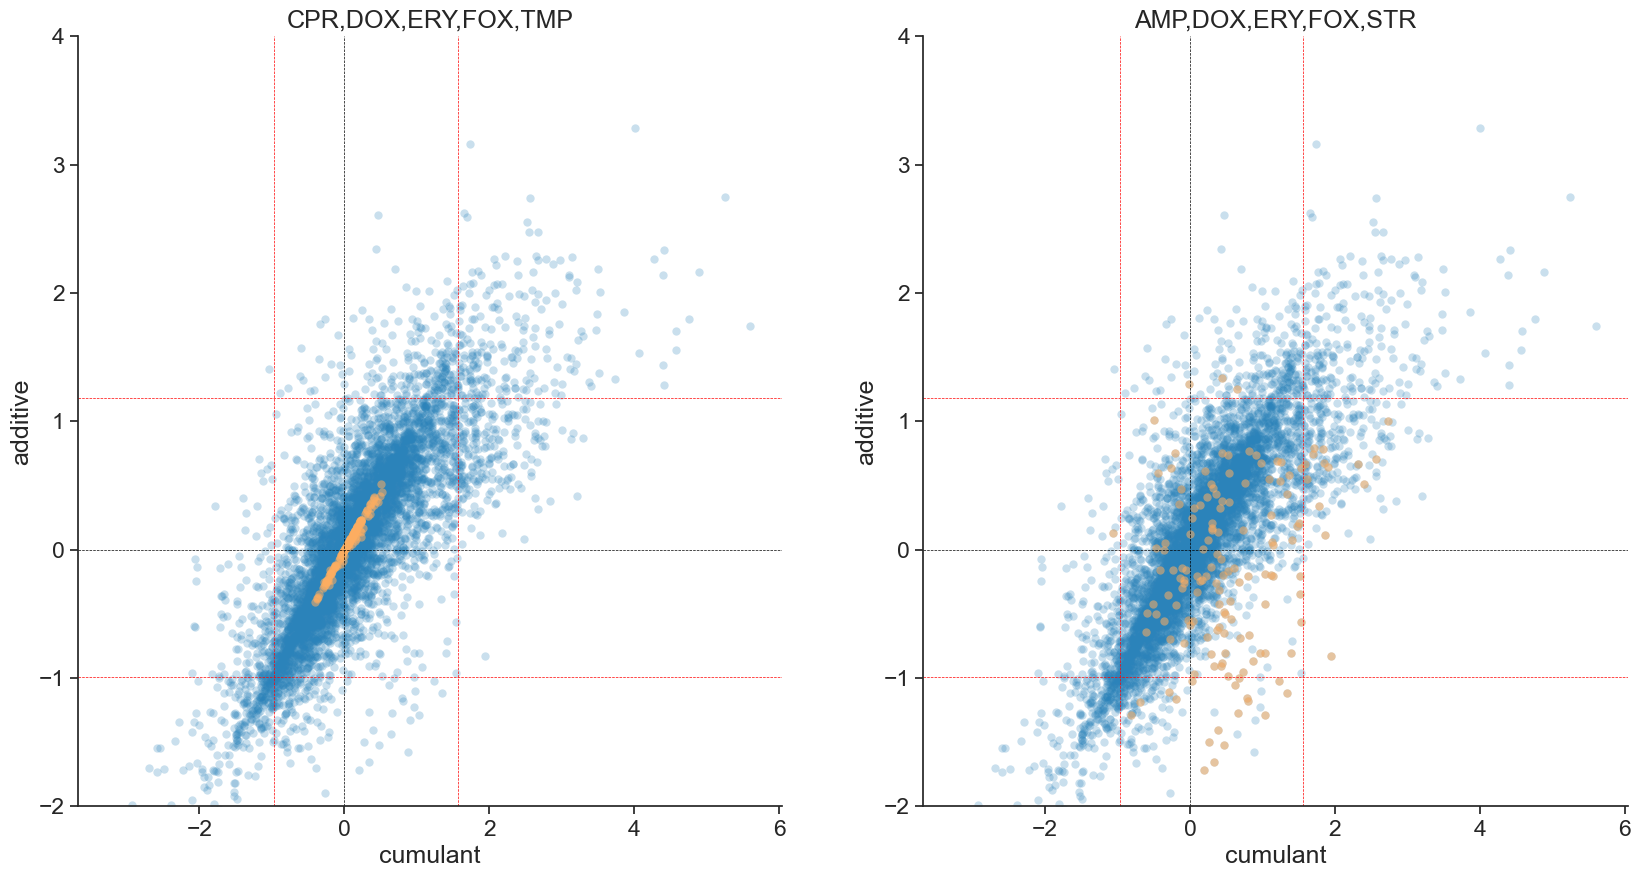

In [11]:
# find drug combinations that have the largest differences b/t multiplicative and cumulant scales

def gather_interaction_combos_into_single_column(df, suff):
    # first add the 'combinations' column so we can keep track drug names
    x = pd.concat([combinations, df.filter(regex=(f".*{suff}"))], axis=1)
    cols = [i for i in x.columns if suff in i]
    x = x.melt(id_vars="combinations", value_vars=cols)
    x.variable = x.variable.str.replace(suff,"")
    return x.rename(columns={"value":suff.replace("_","")})

# for interactions with order below 5, the data are scattered across many columns, e.g. X1X2X3 and X2X3X4 etc.
# for a specific scale (iss or mult), get all the columns and combine them into a single column

iss = gather_interaction_combos_into_single_column(df_quin, "_iss")
add = gather_interaction_combos_into_single_column(df_quin, "_ad")

# combine all iss and mult data into a single data frame
im = iss.merge(add, how="outer", on=["combinations", "variable"])
print("before filtering add for 0's, nan, inf: ",len(im))
im = im[~np.isnan(im.ad) & np.isfinite(im.ad)].reset_index(drop=True)
print("after filtering add for nan, inf: ",len(im))

# sort by iss and mult separately to get ranks, then compute the difference b/t ranks
im = im.sort_values(by="iss").reset_index(drop=True)
im.index.name = "iss_sort"
im = im.reset_index()
im = im.sort_values(by="ad").reset_index(drop=True)
im.index.name = "ad_sort"
im = im.reset_index()
im.loc[:,"rank_diff"] = abs(im['iss_sort'] - im['ad_sort'])

# get values (in terms of rank differences) that represent drug combinations that have the most and least different ranks
rank_diff_upper_outliers = np.quantile(im.rank_diff, 0.95)
rank_diff_lower_outliers = np.quantile(im.rank_diff, 0.05)

print("rank_diff_upper_outliers: ", rank_diff_upper_outliers)
print("rank_diff_lower_outliers: ", rank_diff_lower_outliers)

lower_quant_ad = np.quantile(im.ad, 0.05)
upper_quant_ad = np.quantile(im.ad, 0.95)
lower_quant_iss = np.quantile(im.iss, 0.05)
upper_quant_iss = np.quantile(im.iss, 0.95)

im.variable = im.variable.str.replace("X","")

# the combinations column contains the 5 drugs used within a plate, but not all drugs may have been used in any given experiment
# use the variable column to extract which subset of drugs were actually used for each exp.

drug_combos_concs = []
drug_combos = []
for i,r in im.iterrows():
        #drug_combo = ""
        drug_combo_conc = []
        drug_combo = []
        for l in range(0,len(r.variable)):
            index = int(r.variable[l])
            start = (index-1)*4 # each drug name has length 4: 3 letter name followed by 1 number for concentration
            stop = start+4
            drug_conc = r.combinations[start:stop]
            drug = drug_conc.replace("1","").replace("2","").replace("3","")
            #drug_combo = drug_combo + drug
            drug_combo_conc.append(drug_conc)
            drug_combo.append(drug)
        drug_combos_concs.append("".join(sorted(drug_combo_conc)))
        drug_combos.append("".join(sorted(drug_combo)))
im.loc[:,"drug_combos_concs_subset"] = drug_combos_concs
im.loc[:,"drug_combos_subset"] = drug_combos

def find_drug_combos(df):
    # for a given data frame (prefiltered for some quantile of rank_diff)
    # (1) find the most represented drug combination
    # (2) given that drug combination, get the individual drugs to search for
    
    drug_combos_conc = defaultdict(int)
    drug_combos_unique = defaultdict(int)
    for i,r in df.iterrows():
        #drug_combo = ""
        #for l in range(0,len(r.variable)):
        #    index = int(r.variable[l])
        #    start = (index-1)*4 # each drug name has length 4: 3 letter name followed by 1 number for concentration
        #    stop = start+4
        #    drug = r.combinations[start:stop]
        #    drug_combo = drug_combo + drug
        drug_combos_conc[r['drug_combos_concs_subset']] += 1
    # remove concentration labels to sum across all combinations with the same drug 
    for i in drug_combos_conc:
        drug_combos_unique[i.replace("1","").replace("2","").replace("3","")] += drug_combos_conc[i]
    
    # find most represented drug combination
    tmp = pd.DataFrame.from_dict(drug_combos_unique, orient="index").rename(columns={0:"obs"}).sort_values(by="obs", ascending=False).reset_index().rename(columns={"index":"comb"})
    #tmp = pd.DataFrame.from_dict(drug_combos_conc, orient="index").rename(columns={0:"obs"}).sort_values(by="obs", ascending=False).reset_index().rename(columns={"index":"comb"})

    # CHANGE THIS TO GET THE TOP DRUG, 2ND TOP DRUG, ETC.
    most_represented_drug_combo = tmp.comb[0]
    # for the combination that is the top outlier, extract the individual drugs from the string
    most_represented_drugs = [most_represented_drug_combo[3*i:3*i+3] for i in range(int(len(most_represented_drug_combo)/3))]
    #outlier_ind_drugs = [most_represented_drug_combo[4*i:4*i+4] for i in range(int(len(most_represented_drug_combo)/4))]

    return most_represented_drugs


most_represented_drugs_lower_outliers = find_drug_combos(im[im.rank_diff <= rank_diff_lower_outliers])
most_represented_drugs_upper_outliers = find_drug_combos(im[im.rank_diff >= rank_diff_upper_outliers])

u = np.array([im.drug_combos_concs_subset.str.contains(i) for i in most_represented_drugs_upper_outliers])
l = np.array([im.drug_combos_concs_subset.str.contains(i) for i in most_represented_drugs_lower_outliers])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
def make_scatterplot(cond, title, i):
    transp = 0.25
    sns.scatterplot(x=im.iss, y=im.ad, alpha=transp, color=for_plt['col_ad'], linewidth=0, ax=axs[i])
    sns.scatterplot(x=im[np.all(cond,axis=0)].iss, y=im[np.all(cond,axis=0)].ad, alpha=transp+0.3, color=for_plt['col_iss'], linewidth=0, ax=axs[i])
    axs[i].set_ylim(-2,4)
    axs[i].axvline(0, color="black", linestyle="--", linewidth=0.5)
    axs[i].axhline(0, color="black", linestyle="--", linewidth=0.5)
    axs[i].axhline(lower_quant_ad, color="red", linestyle="--", linewidth=0.5)
    axs[i].axhline(upper_quant_ad, color="red", linestyle="--", linewidth=0.5)
    axs[i].axvline(lower_quant_iss, color="red", linestyle="--", linewidth=0.5)
    axs[i].axvline(upper_quant_iss, color="red", linestyle="--", linewidth=0.5)

    axs[i].set(xlabel="cumulant", ylabel="additive", title=title)

make_scatterplot(l, ",".join(most_represented_drugs_lower_outliers), 0)
make_scatterplot(u, ",".join(most_represented_drugs_upper_outliers), 1)
sns.despine()


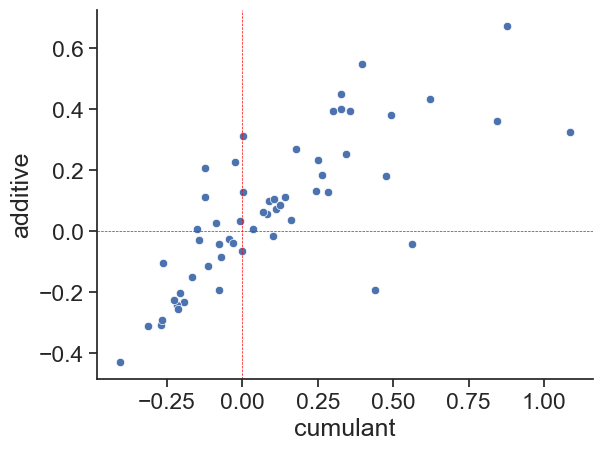

In [12]:
tmp = im[['drug_combos_subset', 'iss', 'ad']].groupby(["drug_combos_subset"]).median().reset_index()
tmp.loc[:, "diff"] = abs(tmp.ad - tmp.iss)

lower_quant_ad = np.quantile(tmp.ad, 0.05)
upper_quant_ad = np.quantile(tmp.ad, 0.95)
lower_quant_iss = np.quantile(tmp.iss, 0.05)
upper_quant_iss = np.quantile(tmp.iss, 0.95)

g = sns.scatterplot(x=tmp.iss, y=tmp.ad)
g.set_xlabel("cumulant")
g.set_ylabel("additive")
g.axhline(0, color="red", linestyle="--", linewidth=0.5)
g.axvline(0, color="red", linestyle="--", linewidth=0.5)


sns.despine()

before filtering add for 0's, nan, inf:  0
before filtering add for 0's, nan, inf:  84000
before filtering add for 0's, nan, inf:  84000
before filtering add for 0's, nan, inf:  42000
before filtering add for 0's, nan, inf:  8400
chimeric skew 3rd-order:  0.3631137457365553
additive skew 3rd-order:  0.3099234427281487
chimeric skew 4th-order:  -0.6326533016714341
additive skew 4th-order:  -0.25807730586465144
chimeric skew 5th-order:  0.8725838827559185
additive skew 5th-order:  0.16744500534602888


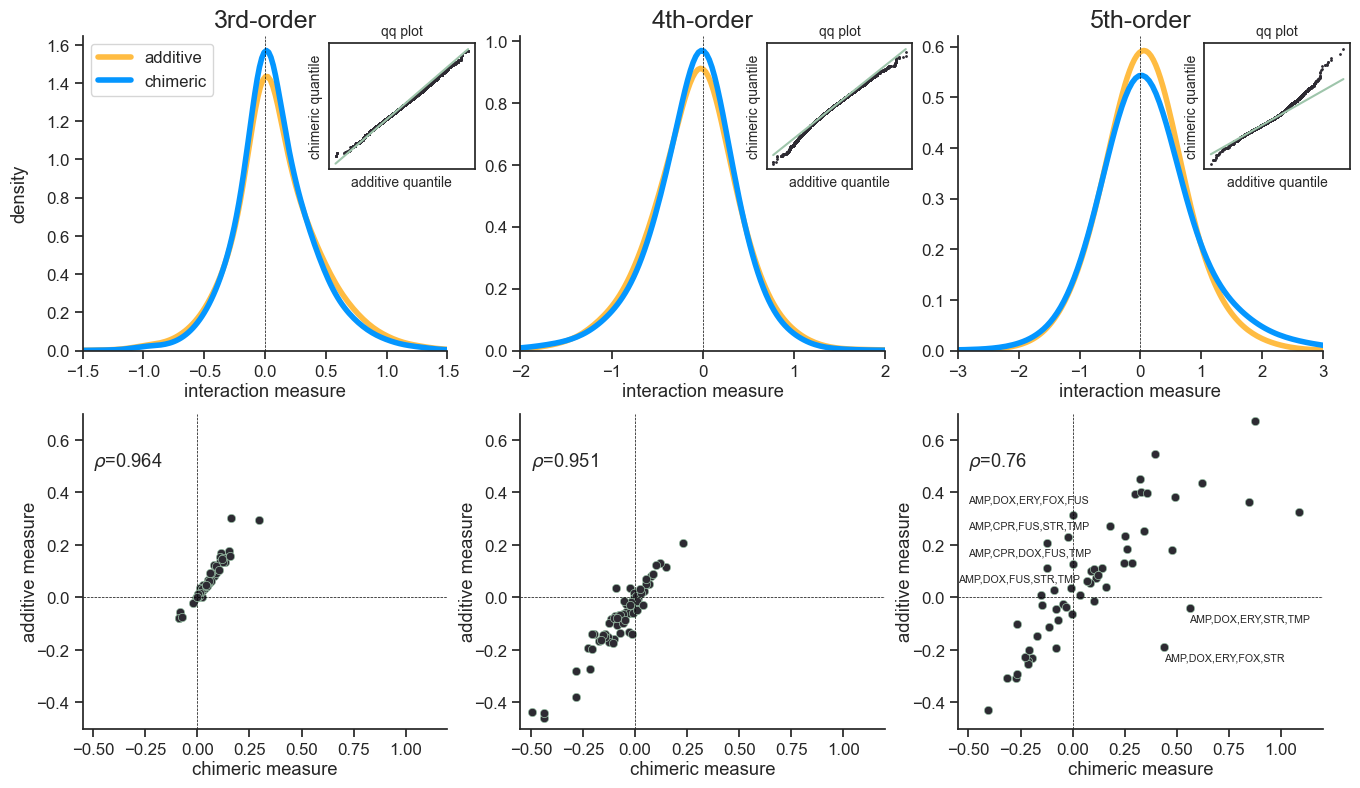

In [13]:
def get_noninf(df):
    x = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    y = np.array(concat_cols(df.filter(regex=(".*_ad"))))
    #x = x[~np.isnan(y) & np.isfinite(y)]
    #y = y[~np.isnan(y) & np.isfinite(y)]
    return x, y

def gather_raw_combos_into_single_column(df):
    # first add the 'combinations' column so we can keep track drug names
    x = pd.concat([combinations, df.filter(regex=(f"^((?!_).)*$"))], axis=1)
    cols = [i for i in x.columns if "X" in i]
    x = x.melt(id_vars="combinations", value_vars=cols)
    return x

def get_drug_combos(df):
    drug_combos_concs = []
    drug_combos = []
    for i,r in df.iterrows():
            #drug_combo = ""
            drug_combo_conc = []
            drug_combo = []
            for l in range(0,len(r.variable)):
                index = int(r.variable[l])
                start = (index-1)*4 # each drug name has length 4: 3 letter name followed by 1 number for concentration
                stop = start+4
                drug_conc = r.combinations[start:stop]
                drug = drug_conc.replace("1","").replace("2","").replace("3","")
                #drug_combo = drug_combo + drug
                drug_combo_conc.append(drug_conc)
                drug_combo.append(drug)
            drug_combos_concs.append("".join(sorted(drug_combo_conc)))
            drug_combos.append("".join(sorted(drug_combo))) 
    return drug_combos, drug_combos_concs

def compute_medians(df):
    iss = gather_interaction_combos_into_single_column(df, "_iss")
    add = gather_interaction_combos_into_single_column(df, "_ad")
    raw = gather_raw_combos_into_single_column(df)
    # combine all iss and mult data into a single data frame
    im = iss.merge(add, how="outer", on=["combinations", "variable"])
    print("before filtering add for 0's, nan, inf: ",len(im))
    im = im[~np.isnan(im.ad) & np.isfinite(im.ad)].reset_index(drop=True)
    im.variable = im.variable.str.replace("X","")
    raw.variable = raw.variable.str.replace("X","")
  
    drug_combos, drug_combos_concs = get_drug_combos(im)
    im.loc[:,"drug_combos_concs_subset"] = drug_combos_concs
    im.loc[:,"drug_combos_subset"] = drug_combos

    drug_combos, drug_combos_concs = get_drug_combos(raw)
    raw.loc[:,"drug_combos_concs_subset"] = drug_combos_concs
    raw.loc[:,"drug_combos_subset"] = drug_combos

    medians = im[['drug_combos_subset', 'iss', 'ad']].groupby(["drug_combos_subset"]).median().reset_index()
    medians_raw = raw[['drug_combos_subset', 'value']].groupby(["drug_combos_subset"]).median().reset_index()

    return medians, medians_raw

def mk_histplot(df, medians, pl, title, col):

    data_iss = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    data_ad = np.array(concat_cols(df.filter(regex=(".*_ad"))))
    print(f"chimeric skew {title}: ", skew(data_iss))
    print(f"additive skew {title}: ", skew(data_ad))

    sns.kdeplot(data=pd.DataFrame(concat_cols(df.filter(regex=(".*_ad")))), x=0, color=pl['col_ad'], ax=axs[0,col], bw_adjust=3, linewidth=4, alpha=1)
    sns.kdeplot(data=pd.DataFrame(concat_cols(df.filter(regex=(".*_iss")))), x=0, color=pl['col_iss'], ax=axs[0,col], bw_adjust=3, linewidth=4, alpha=1)


    left, bottom, width, height = [0.675,0.575,0.4,0.4]
    ins = axs[0,col].inset_axes([left,bottom,width,height])
    ins.plot([min(data_ad),max(data_ad)],[min(data_ad),max(data_ad)], color=pl['compare_edge'], linestyle='-', linewidth=1.5)
    ins.scatter(np.sort(data_ad), np.sort(data_iss), color=pl['compare_dot'], s=1)
    ins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ins.set_ylabel("chimeric quantile", fontsize=10)
    ins.set_xlabel("additive quantile", fontsize=10)
    ins.set_title("qq plot", fontsize=10)

    if col==0:
        axs[0,col].set(xlabel="interaction measure", ylabel="density")
    else:
        axs[0,col].set(xlabel="interaction measure", ylabel="")
    #add legend
    if col==0:
        custom_lines = [Line2D([0], [0], color=pl['col_ad'], lw=4),
                        Line2D([0], [0], color=pl['col_iss'], lw=4)]
        axs[0,col].legend(custom_lines, ['additive', 'chimeric'], loc='upper left', fontsize=12)

    axs[0,col].set_title(title, fontsize=18)
    #axs[0,col].set_xlim(-3,4)
    axs[0,col].set_xlim(for_plt[f'col{col}'][0], for_plt[f'col{col}'][1])
    axs[0,col].axvline(0, color="black", linestyle="--", linewidth=0.5)
    axs[0,col].xaxis.set_label_coords(x=0.5, y=-0.1)
    axs[0,col].yaxis.set_label_coords(x=-0.15, y=0.5)

    x, y = get_noninf(df)
    rho = str(round(scipy.stats.pearsonr(x,y)[0], 3))
    """
    sns.scatterplot(x=x, 
                y=y,   
                alpha=pl['transparency'], color=pl['col_ad'], linewidth=0,
                ax=axs[1,col])
    axs[1,col].set(xlabel="cumulant", ylabel="additive")
    axs[1,col].xaxis.set_label_coords(x=0.5, y=-0.1)
    axs[1,col].yaxis.set_label_coords(x=-0.12, y=0.5)


    axs[1,col].axvline(0, color="black", linestyle="--", linewidth=0.5)
    axs[1,col].axhline(0, color="black", linestyle="--", linewidth=0.5)
    axs[1,col].set_ylim(-3,4)
    axs[1,col].set_xlim(-3,4)
    #axs[row,1].axline([0,1], [80, 81], linestyle="--", color="black")
    axs[1,col].text(x=-2.5, y=3, s=r"$\rho$="+rho)
    """
    sns.scatterplot(x=medians.iss, y=medians.ad, ax=axs[1,col], color=pl['compare_dot'], edgecolor=pl['compare_edge'])
    rho = str(round(scipy.stats.pearsonr(medians.iss,medians.ad)[0], 3))
    axs[1,col].set_xlabel("chimeric measure")
    axs[1,col].set_ylabel("additive measure")
    axs[1,col].axhline(0, color="black", linestyle="--", linewidth=0.5)
    axs[1,col].axvline(0, color="black", linestyle="--", linewidth=0.5)

    axs[1,col].set(xlabel="chimeric measure", ylabel="additive measure")
    axs[1,col].xaxis.set_label_coords(x=0.5, y=-0.1)
    axs[1,col].yaxis.set_label_coords(x=-0.12, y=0.5)
    axs[1,col].set_ylim(-0.5,0.7)
    axs[1,col].set_xlim(-0.55,1.2)
    axs[1,col].text(x=-0.5, y=0.5, s=r"$\rho$="+rho)


sns.set(font_scale = 1.1)
sns.set_style("ticks")
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))

for_plt = {}
for_plt['binwid'] = 0.15
for_plt['transparency']=0.1


for_plt['compare_edge'] = "#9EC5AB"
for_plt['compare_dot'] = '#2D2A32'

for_plt['col_iss'] = "#0496FF"
for_plt['col_ad'] = "#FFBC42"
#for_plt['edgecol_iss'] = "#fdae61"
#for_plt['edgecol_ad'] = "#2b83ba"

for_plt['col0'] = [-1.5,1.5]
for_plt['col1'] = [-2,2]
for_plt['col2'] = [-3,3]

##################

medians_1, medians_raw_1 = compute_medians(df_sing)
medians_2, medians_raw_2 = compute_medians(df_doub)
medians_3, medians_raw_3 = compute_medians(df_trip)
medians_4, medians_raw_4 = compute_medians(df_quad)
medians_5, medians_raw_5 = compute_medians(df_quin)

mk_histplot(df_trip, medians_3, for_plt, "3rd-order", 0)
mk_histplot(df_quad, medians_4, for_plt, "4th-order", 1)
mk_histplot(df_quin, medians_5, for_plt, "5th-order", 2)

axs[1,2].text(x=0.439, y=-0.19-0.05, s=",".join(sorted(['AMP','DOX','ERY','STR','FOX'])), fontsize='xx-small')
axs[1,2].text(x=0.56, y=-0.0423045-0.05, s=",".join(sorted(['AMP','DOX','ERY','STR','TMP'])), fontsize='xx-small')
axs[1,2].text(x=-0.5, y=0.26, s=",".join(sorted(['AMP','CPR','FUS','STR','TMP'])), fontsize='xx-small')
axs[1,2].text(x=-0.5, y=0.16, s=",".join(sorted(['AMP','DOX','FUS','TMP','CPR'])), fontsize='xx-small')
axs[1,2].text(x=-0.55, y=0.06, s=",".join(sorted(['AMP','DOX','FUS','STR','TMP'])), fontsize='xx-small')
axs[1,2].text(x=-0.5, y=0.36, s=",".join(sorted(['AMP','DOX','FUS','ERY','FOX'])), fontsize='xx-small')

sns.despine()
plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/panels_tmp/mutidrug.pdf', bbox_inches = "tight")


/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Count'>

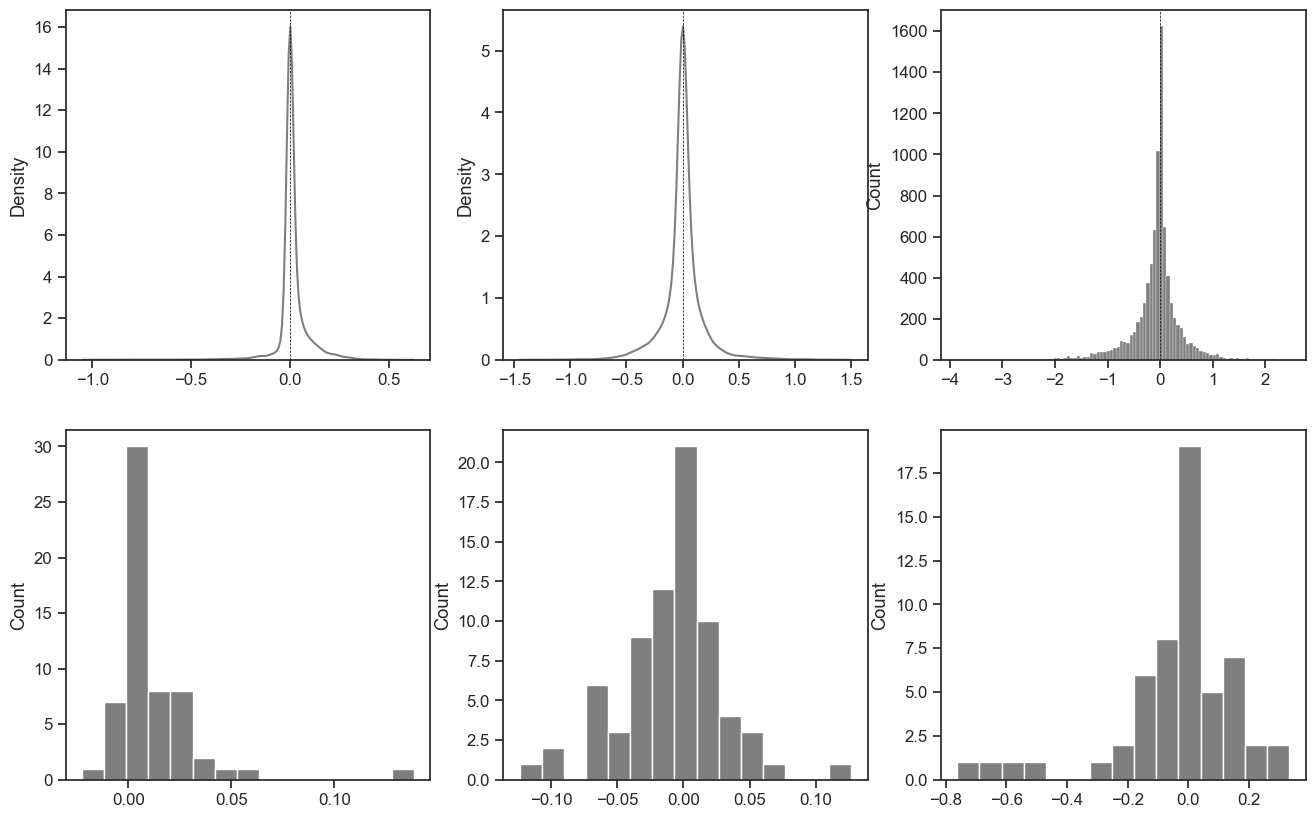

In [14]:
def compute_diff(df):
    ad = concat_cols(df.filter(regex=(".*ad")))
    iss = concat_cols(df.filter(regex=(".*iss")))
    return np.array(ad) - np.array(iss)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,10))

sns.kdeplot(compute_diff(df_trip), color="black", alpha=0.5, ax = axs[0,0], bw=0.2)
sns.kdeplot(compute_diff(df_quad), color="black", alpha=0.5, ax = axs[0,1], bw=0.2)
#sns.kdeplot(compute_diff(df_quin), color="black", alpha=0.5, ax = axs[0,2], bw=0.2)
sns.histplot(compute_diff(df_quin), color="black", alpha=0.5, ax = axs[0,2], bins=100)

axs[0,0].axvline(0, color="black", linestyle="--", linewidth=0.5)
axs[0,1].axvline(0, color="black", linestyle="--", linewidth=0.5)
axs[0,2].axvline(0, color="black", linestyle="--", linewidth=0.5)

sns.histplot(compute_diff(medians_3), bins=15, color="black", alpha=0.5, ax = axs[1,0])
sns.histplot(compute_diff(medians_4), bins=15, color="black", alpha=0.5, ax = axs[1,1])
sns.histplot(compute_diff(medians_5), bins=15, color="black", alpha=0.5, ax = axs[1,2])





In [15]:
from scipy.stats import ttest_rel

def ttest(df, test):
    ad = np.array(concat_cols(df.filter(regex=(".*ad"))))
    iss = np.array(concat_cols(df.filter(regex=(".*iss"))))
    ad = ad[~np.isnan(ad) & ~np.isnan(iss)]
    iss = iss[~np.isnan(ad) & ~np.isnan(iss)]
    #print(np.mean(ad), np.mean(iss))
    #print(np.median(ad), np.median(iss))
    print(ttest_rel(ad, iss, alternative=test))

ttest(df_quin, "less")
ttest(medians_5, "less")
print("----")
ttest(df_quad, "two-sided")
ttest(medians_4, "two-sided")
print("----")
ttest(df_trip, "greater")
ttest(medians_3, "greater")

Ttest_relResult(statistic=-13.75449234400879, pvalue=6.9124907017396665e-43)
Ttest_relResult(statistic=-1.30805459497941, pvalue=0.0981477557729353)
----
Ttest_relResult(statistic=2.8662556421543464, pvalue=0.004155650145905916)
Ttest_relResult(statistic=-1.7589311717176932, pvalue=0.0828379176124864)
----
Ttest_relResult(statistic=52.14849619314965, pvalue=0.0)
Ttest_relResult(statistic=3.923854246509557, pvalue=0.00011674540661169896)


In [16]:
# compute sign switches
def compute_sign_switches(df):
    ad = np.array(concat_cols(df.filter(regex=(".*ad"))))
    iss = np.array(concat_cols(df.filter(regex=(".*iss"))))
    ad = ad[~np.isnan(ad) & ~np.isnan(iss)]
    iss = iss[~np.isnan(ad) & ~np.isnan(iss)]
    assert len(ad) == len(iss)
    ad_pos_iss_neg = np.sum((ad > 0) & (iss < 0))
    ad_neg_iss_pos = np.sum((ad < 0) & (iss > 0))
    sign_switches = ad_pos_iss_neg + ad_neg_iss_pos
    print(ad_pos_iss_neg, ad_neg_iss_pos, sign_switches, len(ad), sign_switches/len(ad))
    #print(sign_switches/len(ad))
    return sign_switches/len(ad)

# compute correlations
def compute_correlation(df):
    ad = np.array(concat_cols(df.filter(regex=(".*ad"))))
    iss = np.array(concat_cols(df.filter(regex=(".*iss"))))
    ad = ad[~np.isnan(ad) & ~np.isnan(iss)]
    iss = iss[~np.isnan(ad) & ~np.isnan(iss)]
    assert len(ad) == len(iss)
    #print(round(scipy.stats.pearsonr(ad,iss)[0], 3))
    return round(scipy.stats.pearsonr(ad,iss)[0], 3)

print("SIGN SWITCHES")
print("raw5", compute_sign_switches(df_quin))
print("median5", compute_sign_switches(medians_5))
print("----")
print("raw4", compute_sign_switches(df_quad))
print("median4", compute_sign_switches(medians_4))
print("----")
print("raw3", compute_sign_switches(df_trip))
print("median3", compute_sign_switches(medians_3))
print("----")

print("CORRELATIONS")
print("raw5", compute_correlation(df_quin))
print("median5", compute_correlation(medians_5))
print("----")
print("raw4", compute_correlation(df_quad))
print("median4", compute_correlation(medians_4))
print("----")
print("raw3", compute_correlation(df_trip))
print("median3", compute_correlation(medians_3))
print("----")

SIGN SWITCHES
567 591 1158 8400 0.13785714285714284
raw5 0.13785714285714284
6 3 9 56 0.16071428571428573
median5 0.16071428571428573
----
1317 1640 2957 42000 0.0704047619047619
raw4 0.0704047619047619
4 7 11 73 0.1506849315068493
median4 0.1506849315068493
----
1404 731 2135 84000 0.025416666666666667
raw3 0.025416666666666667
0 0 0 59 0.0
median3 0.0
----
CORRELATIONS
raw5 0.803
median5 0.76
----
raw4 0.928
median4 0.951
----
raw3 0.975
median3 0.964
----


1404 731 2135 84000 0.025416666666666667
1317 1640 2957 42000 0.0704047619047619
567 591 1158 8400 0.13785714285714284
0 0 0 59 0.0
4 7 11 73 0.1506849315068493
6 3 9 56 0.16071428571428573


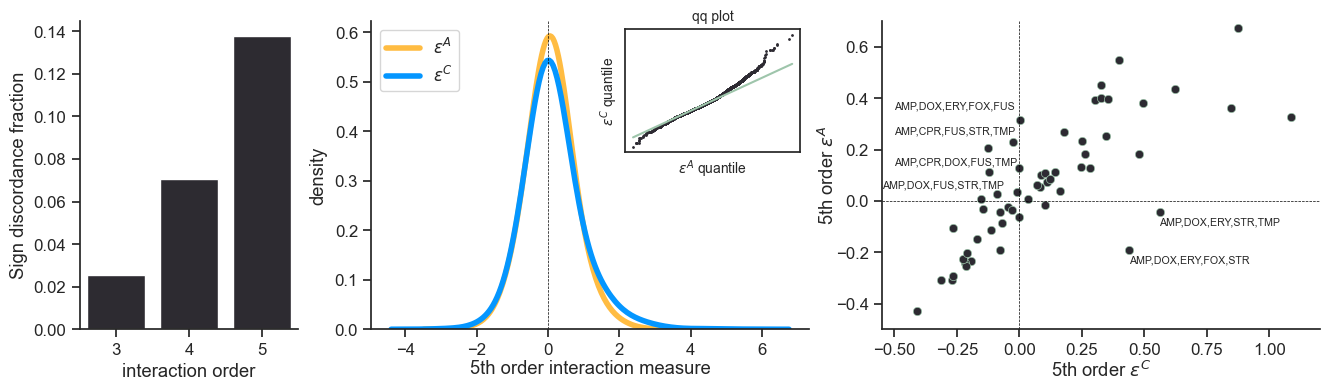

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4), gridspec_kw={'width_ratios': [1,2,2]})

# plot correlations of raw data and medians
x = [3,4,5]
raws = [compute_sign_switches(df_trip), compute_sign_switches(df_quad), compute_sign_switches(df_quin)]
medians = [compute_sign_switches(medians_3), compute_sign_switches(medians_4), compute_sign_switches(medians_5)]
g = sns.barplot(x=x, y=raws, color=for_plt['compare_dot'], ax=axs[0])
#sns.lineplot(x=x, y=medians, color=for_plt['compare_dot'], label="median", marker="o", ax=axs[0])
#g.set_xticks(x)
g.set_xlabel("interaction order")
g.set_ylabel("Sign discordance fraction")

g = sns.kdeplot(data=pd.DataFrame(concat_cols(df_quin.filter(regex=(".*_ad")))), x=0, color=for_plt['col_ad'], ax=axs[1], bw_adjust=3, linewidth=4, alpha=1)
sns.kdeplot(data=pd.DataFrame(concat_cols(df_quin.filter(regex=(".*_iss")))), x=0, color=for_plt['col_iss'], ax=axs[1], bw_adjust=3, linewidth=4, alpha=1)

data_ad = np.array(concat_cols(df_quin.filter(regex=(".*_ad"))))
data_iss = np.array(concat_cols(df_quin.filter(regex=(".*_iss"))))
left, bottom, width, height = [0.58,0.575,0.4,0.4]
ins = axs[1].inset_axes([left,bottom,width,height])
ins.plot([min(data_ad),max(data_ad)],[min(data_ad),max(data_ad)], color=for_plt['compare_edge'], linestyle='-', linewidth=1.5)
ins.scatter(np.sort(data_ad), np.sort(data_iss), color=for_plt['compare_dot'], s=1)
ins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ins.set_ylabel(r'$\epsilon^C$ quantile', fontsize=10)
ins.set_xlabel(r'$\epsilon^A$ quantile', fontsize=10)
ins.set_title("qq plot", fontsize=10)

axs[1].set(xlabel="5th order interaction measure", ylabel="density")

#add legend
custom_lines = [Line2D([0], [0], color=for_plt['col_ad'], lw=4),
                Line2D([0], [0], color=for_plt['col_iss'], lw=4)]
axs[1].legend(custom_lines, [r'$\epsilon^A$', r'$\epsilon^C$'], loc='upper left', fontsize=12)

axs[1].axvline(0, color="black", linestyle="--", linewidth=0.5)
axs[1].xaxis.set_label_coords(x=0.5, y=-0.1)
axs[1].yaxis.set_label_coords(x=-0.1, y=0.5)

sns.scatterplot(x=medians_5.iss, y=medians_5.ad, ax=axs[2], color=for_plt['compare_dot'], edgecolor=for_plt['compare_edge'])
axs[2].set_xlabel(r'5th order $\epsilon^C$')
axs[2].set_ylabel(r'5th order $\epsilon^A$')
axs[2].axhline(0, color="black", linestyle="--", linewidth=0.5)
axs[2].axvline(0, color="black", linestyle="--", linewidth=0.5)

axs[2].xaxis.set_label_coords(x=0.5, y=-0.1)
axs[2].yaxis.set_label_coords(x=-0.1, y=0.5)
axs[2].set_ylim(-0.5,0.7)
axs[2].set_xlim(-0.55,1.2)


#axs[2].text(x=0.439, y=-0.19-0.05, s=",".join(sorted(['AMP','DOX','ERY','STR','FOX'])), fontsize='xx-small')
#axs[2].text(x=0.56, y=-0.0423045-0.05, s=",".join(sorted(['AMP','DOX','ERY','STR','TMP'])), fontsize='xx-small')
#axs[2].text(x=-0.5, y=0.26, s=",".join(sorted(['AMP','DOX','FUS','TMP','CPR'])), fontsize='xx-small')
#axs[2].text(x=-0.5, y=0.36, s=",".join(sorted(['AMP','DOX','FUS','ERY','FOX'])), fontsize='xx-small')

axs[2].text(x=0.439, y=-0.19-0.05, s=",".join(sorted(['AMP','DOX','ERY','STR','FOX'])), fontsize='xx-small')
axs[2].text(x=0.56, y=-0.0423045-0.05, s=",".join(sorted(['AMP','DOX','ERY','STR','TMP'])), fontsize='xx-small')
axs[2].text(x=-0.5, y=0.26, s=",".join(sorted(['AMP','CPR','FUS','STR','TMP'])), fontsize='xx-small')
axs[2].text(x=-0.5, y=0.14, s=",".join(sorted(['AMP','DOX','FUS','TMP','CPR'])), fontsize='xx-small')
axs[2].text(x=-0.55, y=0.05, s=",".join(sorted(['AMP','DOX','FUS','STR','TMP'])), fontsize='xx-small')
axs[2].text(x=-0.5, y=0.36, s=",".join(sorted(['AMP','DOX','FUS','ERY','FOX'])), fontsize='xx-small')
sns.despine()
plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/drug_analyses.pdf', bbox_inches = "tight")


In [18]:
medians_2
from scipy.special import binom
print(len(medians_2), binom(8,2))
print(len(medians_3), binom(8,3))
print(len(medians_4), binom(8,4))
print(len(medians_5), binom(8,5))

29 28.0
59 56.0
73 70.0
56 56.0


In [19]:
scipy.stats.kstest(concat_cols(df_quin.filter(regex=(".*_ad"))), 
                   concat_cols(df_quin.filter(regex=(".*_iss"))),
                   alternative="greater")

KstestResult(statistic=0.041428571428571426, pvalue=5.461288434177082e-07)

<AxesSubplot:xlabel='ad', ylabel='Density'>

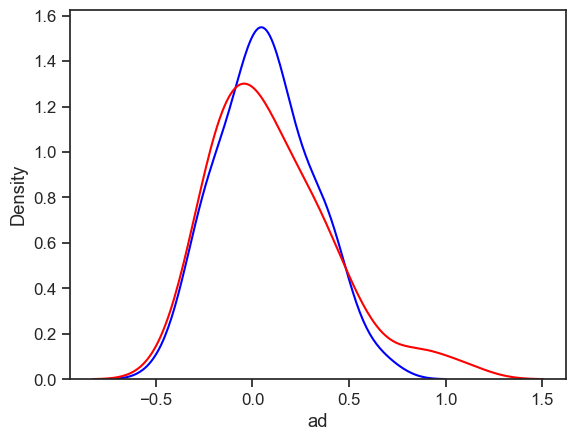

In [20]:
sns.kdeplot(medians_5.ad, color="blue")
sns.kdeplot(medians_5.iss, color="red")

In [21]:
scipy.stats.kstest(medians_5.ad, 
                   medians_5.iss,
                   alternative="greater")

KstestResult(statistic=0.08928571428571429, pvalue=0.6420779315085001)

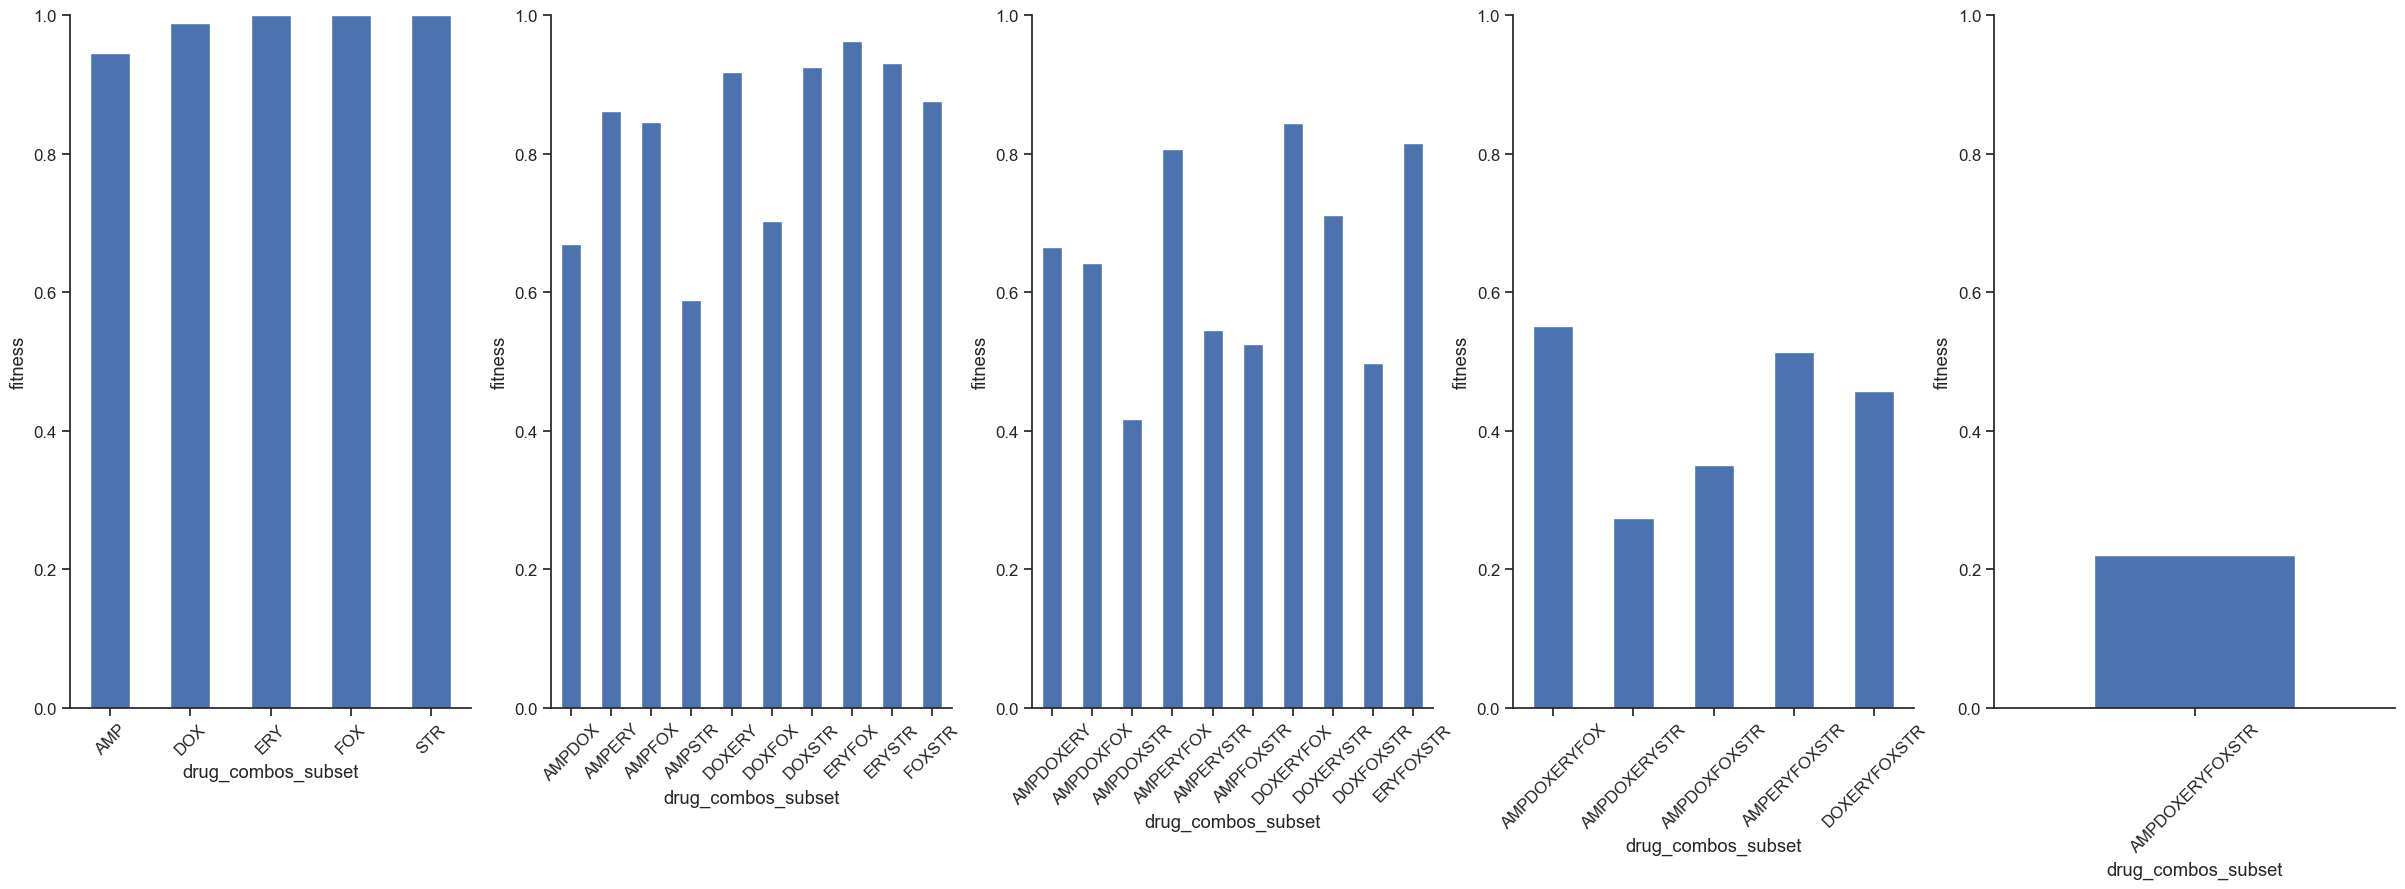

In [22]:
five_drug_string = "AMPDOXERYFOXSTR" # cumulant,additive = 0.439538,-0.190832
#five_drug_string = "AMPDOXERYSTRTMP" # cumulant,additive = 0.563413, -0.042304

#five_drug_string = "CPRDOXERYFOXTMP" # cumulant,additive = 0.068418,0.063625
#five_drug_string = "AMPDOXERYFUSTMP" # cumulant,additive = -0.031099,-0.037275

#five_drug_string = "AMPCPRDOXSTRTMP" # cumulant,additive = -0.407700,-0.430000
#five_drug_string = "AMPCPRFOXFUSTMP" # cumulant,additive = -0.314214, -0.308895
#five_drug_string = "AMPCPRDOXFOXTMP" # cumulant,additive = -0.271416, -0.307910


#five_drug_string = "CPRFOXFUSSTRTMP" # cumulant,additive = 0.355183,0.395910
#five_drug_string = "AMPCPRERYFUSSTR" # cumulant,additive = 0.621395,0.435187
#five_drug_string = "AMPDOXERYFOXFUS" # cumulant,additive = 0.001207,0.313875


starts = [0,3,6,9,12]

def get_drug_subsets(five_drug_string, starts, subset_size):
    drug_combos = []
    for comb in itertools.combinations(starts,subset_size):
        drug_combo = ""
        for i in comb:
            drug_combo += five_drug_string[i:i+3]
        drug_combos.append(drug_combo)
    return drug_combos

drug_combos_1 = get_drug_subsets(five_drug_string, starts, 1)
drug_combos_2 = get_drug_subsets(five_drug_string, starts, 2)
drug_combos_3 = get_drug_subsets(five_drug_string, starts, 3)
drug_combos_4 = get_drug_subsets(five_drug_string, starts, 4)
drug_combos_5 = get_drug_subsets(five_drug_string, starts, 5)



def plot_bar(df, i):
    df.plot.bar(x='drug_combos_subset', y='value', rot=45, ax=axs[i])
    axs[i].set_ylim(0,1)
    axs[i].set_ylabel('fitness')
    axs[i].get_legend().remove()
    
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,9))

plot_bar(medians_raw_1[medians_raw_1.drug_combos_subset.isin(drug_combos_1)], 0)
plot_bar(medians_raw_2[medians_raw_2.drug_combos_subset.isin(drug_combos_2)], 1)
plot_bar(medians_raw_3[medians_raw_3.drug_combos_subset.isin(drug_combos_3)], 2)
plot_bar(medians_raw_4[medians_raw_4.drug_combos_subset.isin(drug_combos_4)], 3)
plot_bar(medians_raw_5[medians_raw_5.drug_combos_subset.isin(drug_combos_5)], 4)
sns.despine()

In [23]:

"""
def gather_interaction_combos_into_single_column(df, suff):
    # first add the 'combinations' column so we can keep track drug names
    x = pd.concat([combinations, df.filter(regex=(f".*{suff}"))], axis=1)
    cols = [i for i in x.columns if suff in i]
    x = x.melt(id_vars="combinations", value_vars=cols)
    x.variable = x.variable.str.replace(suff,"")
    return x.rename(columns={"value":suff.replace("_","")})
    """

#df_trip.filter(regex=(f"^((?!_).)*$"))
df_trip.columns



Index(['X1X2X3', 'X1X2X4', 'X1X2X5', 'X1X3X4', 'X1X3X5', 'X1X4X5', 'X2X3X4',
       'X2X3X5', 'X2X4X5', 'X3X4X5', 'X1X2X3_iss', 'X1X2X3_ad', 'X1X2X4_iss',
       'X1X2X4_ad', 'X1X2X5_iss', 'X1X2X5_ad', 'X1X3X4_iss', 'X1X3X4_ad',
       'X1X3X5_iss', 'X1X3X5_ad', 'X1X4X5_iss', 'X1X4X5_ad', 'X2X3X4_iss',
       'X2X3X4_ad', 'X2X3X5_iss', 'X2X3X5_ad', 'X2X4X5_iss', 'X2X4X5_ad',
       'X3X4X5_iss', 'X3X4X5_ad'],
      dtype='object')

vals    float64
dtype: object

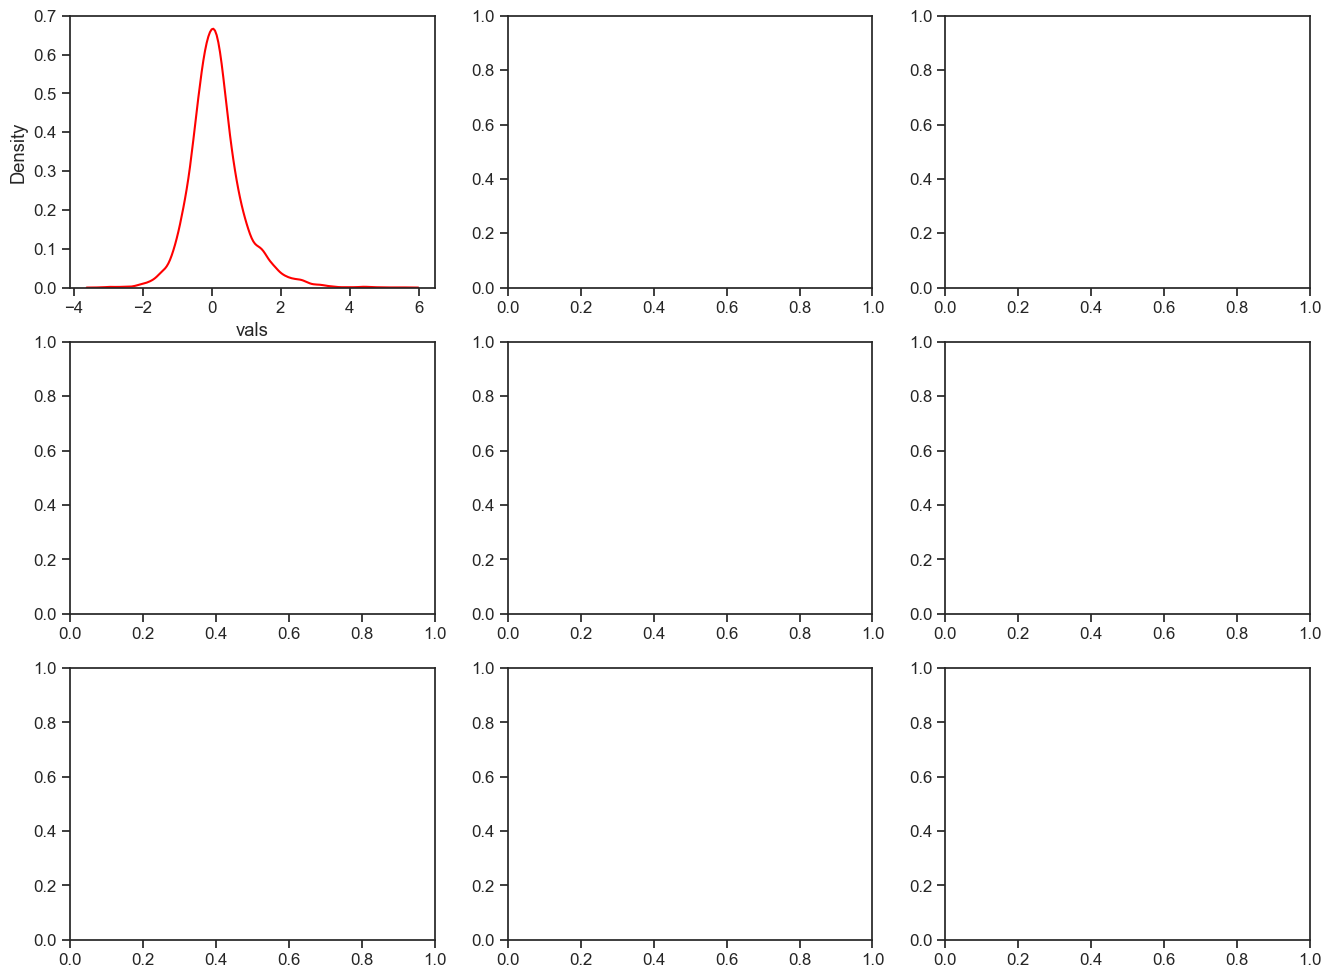

In [24]:
#pd.DataFrame(concat_cols(df_quin.filter(regex=(".*_iss"))))
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16,12))
x = pd.DataFrame(concat_cols(df_quin.filter(regex=(".*_iss")))).rename(columns={0:"vals"})
sns.kdeplot(data=x, 
            x="vals", 
            color="red", 
            ax=axs[0,0])
x.dtypes

In [25]:
tmp[(tmp.ad > upper_quant_ad) & (tmp.iss < upper_quant_iss)]
tmp[(tmp.ad < lower_quant_ad) & (tmp.iss > lower_quant_iss)]

,drug_combos_subset,iss,ad,diff


In [26]:
tmp[(tmp.ad < upper_quant_ad) & (tmp.iss > upper_quant_iss)]

,drug_combos_subset,iss,ad,diff
36,CPRDOXERYFOXSTR,1.087555,0.326245,0.76131
43,CPRDOXFOXSTRTMP,0.845295,0.363085,0.48221


In [27]:
print(binom(8,3))
print(len(im.drug_combos_subset.unique()))
print(sorted(im.drug_combos_subset.unique()))

56.0
56
['AMPCPRDOXERYFOX', 'AMPCPRDOXERYFUS', 'AMPCPRDOXERYSTR', 'AMPCPRDOXERYTMP', 'AMPCPRDOXFOXFUS', 'AMPCPRDOXFOXSTR', 'AMPCPRDOXFOXTMP', 'AMPCPRDOXFUSSTR', 'AMPCPRDOXFUSTMP', 'AMPCPRDOXSTRTMP', 'AMPCPRERYFOXFUS', 'AMPCPRERYFOXSTR', 'AMPCPRERYFOXTMP', 'AMPCPRERYFUSSTR', 'AMPCPRERYFUSTMP', 'AMPCPRERYSTRTMP', 'AMPCPRFOXFUSSTR', 'AMPCPRFOXFUSTMP', 'AMPCPRFOXSTRTMP', 'AMPCPRFUSSTRTMP', 'AMPDOXERYFOXFUS', 'AMPDOXERYFOXSTR', 'AMPDOXERYFOXTMP', 'AMPDOXERYFUSSTR', 'AMPDOXERYFUSTMP', 'AMPDOXERYSTRTMP', 'AMPDOXFOXFUSSTR', 'AMPDOXFOXFUSTMP', 'AMPDOXFOXSTRTMP', 'AMPDOXFUSSTRTMP', 'AMPERYFOXFUSSTR', 'AMPERYFOXFUSTMP', 'AMPERYFOXSTRTMP', 'AMPERYFUSSTRTMP', 'AMPFOXFUSSTRTMP', 'CPRDOXERYFOXFUS', 'CPRDOXERYFOXSTR', 'CPRDOXERYFOXTMP', 'CPRDOXERYFUSSTR', 'CPRDOXERYFUSTMP', 'CPRDOXERYSTRTMP', 'CPRDOXFOXFUSSTR', 'CPRDOXFOXFUSTMP', 'CPRDOXFOXSTRTMP', 'CPRDOXFUSSTRTMP', 'CPRERYFOXFUSSTR', 'CPRERYFOXFUSTMP', 'CPRERYFOXSTRTMP', 'CPRERYFUSSTRTMP', 'CPRFOXFUSSTRTMP', 'DOXERYERYFUSSTR', 'DOXERYFOXFUSSTR', 'DO

In [28]:
iss = gather_interaction_combos_into_single_column(df_quin, "_iss")


In [29]:
u

array([[False, False, False, ...,  True, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [30]:
print(3**5)
scipy.special.binom(8,5)*(3**5)

243


13608.0

KeyError: 'edgecol_ad'

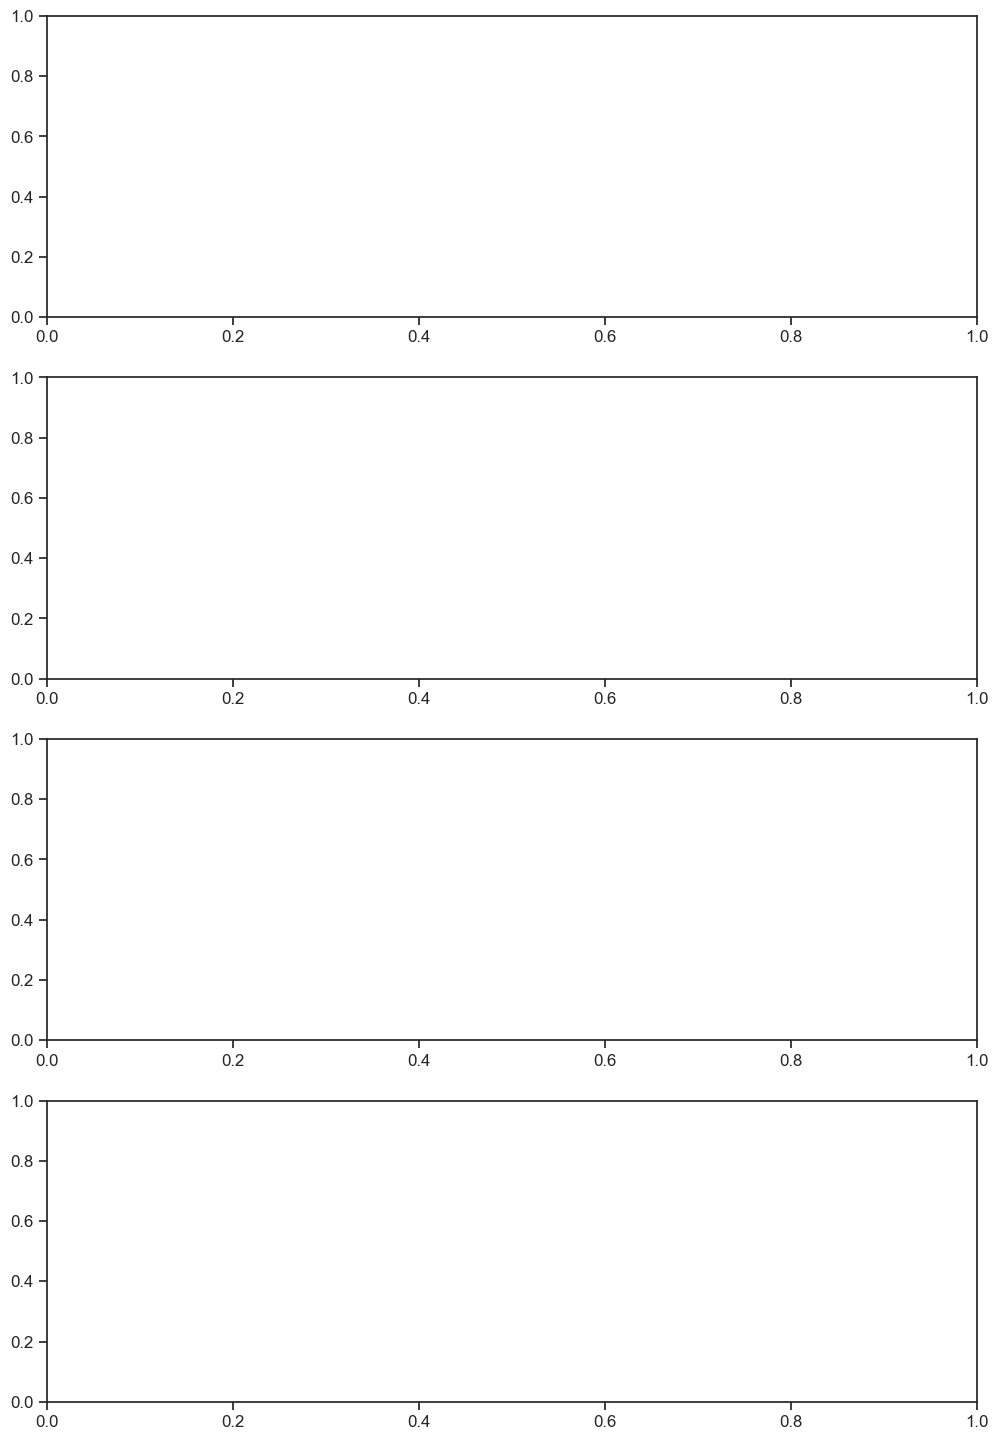

In [31]:

def get_noninf(df):
    y = np.array(concat_cols(df.filter(regex=(".*_ad"))))
    x = np.array([i+0.000000001 if i == 0 else i for i in y[np.isfinite(y)]])
    return x

def mk_histplot(df, pl, title, row):
    sns.histplot(get_noninf(df), binwidth=pl['binwid'], color=pl['col_ad'], edgecolor=pl['edgecol_ad'], ax=axs[row], log_scale=True)
    if row < 3:
        axs[row].set(xlabel=None, ylabel=title, xticklabels=[])
    else:
        axs[row].set(xlabel="interaction score", ylabel=title)
    axs[row].set_xlim(0,10)
    axs[row].axvline(1, color="black", linestyle="--", linewidth=0.5)

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,3))
fig.set_size_inches(12, 18)

mk_histplot(df_doub, for_plt, "2nd-order", 0)
mk_histplot(df_trip, for_plt, "3rd-order", 1)
mk_histplot(df_quad, for_plt, "4th-order", 2)
mk_histplot(df_quin, for_plt, "5th-order", 3)


sns.despine()


NOTE: for correlation analyses, there are some duplicate measurements in these data... although they don't have the exact same values across experiments

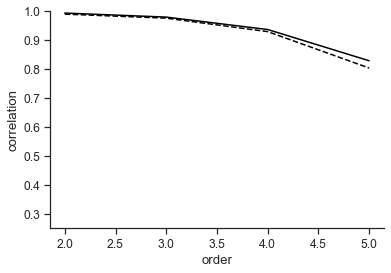

In [ ]:
correlations = []
means = []
medians = []
stds = []
orders = [2,3,4,5]

for i, tmp_df in enumerate([df_doub, df_trip, df_quad, df_quin]):
        d = { "iss" : concat_cols(tmp_df.filter(regex=(".*_iss"))),
                "mult" : concat_cols(tmp_df.filter(regex=(".*_ad"))) }
        tmp = pd.DataFrame.from_dict(d)
        correlations.append( [orders[i], tmp.corr(method="pearson").mult[0], tmp.corr(method="spearman").mult[0]] ) 
        means.append( [orders[i], np.nanmean(tmp.iss), np.nanmean(tmp.mult[np.isfinite(tmp.mult)])] )
        medians.append( [orders[i], np.nanmedian(tmp.iss), np.nanmedian(tmp.mult[np.isfinite(tmp.mult)])] )
        stds.append( [orders[i], np.nanstd(tmp.iss), np.nanstd(tmp.mult[np.isfinite(tmp.mult)])] )

corrs = pd.DataFrame(correlations, columns=["order", "pearson", "spearman"])
means = pd.DataFrame(means, columns=["order", "isserlis", "multiplicative"])
medians = pd.DataFrame(medians, columns=["order", "isserlis", "multiplicative"])
stds = pd.DataFrame(stds, columns=["order", "isserlis", "multiplicative"])


p=sns.lineplot(data=corrs, x="order", y="pearson", color="black", linestyle="--")
p=sns.lineplot(data=corrs, x="order", y="spearman", color="black")
p.set(ylabel="correlation")
p.set_ylim(0.25, 1)
sns.despine()


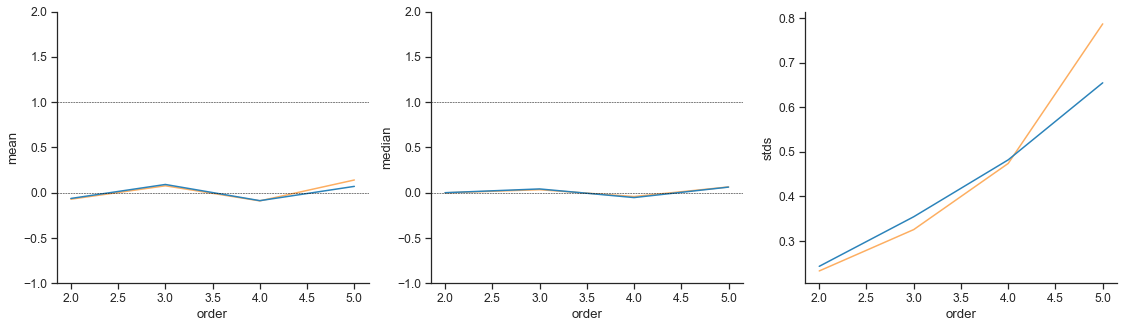

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19,5))

sns.lineplot(data=means, x="order", y="isserlis", color=for_plt['col_iss'], ax=axs[0])
sns.lineplot(data=means, x="order", y="multiplicative", color=for_plt['col_ad'], ax=axs[0])
axs[0].set(ylabel="mean")
axs[0].set_ylim(-1,2)
axs[0].axhline(0, color="black", linestyle="--", linewidth=0.5)
axs[0].axhline(1, color="black", linestyle="--", linewidth=0.5)
sns.lineplot(data=medians, x="order", y="isserlis", color=for_plt['col_iss'], ax=axs[1])
sns.lineplot(data=medians, x="order", y="multiplicative", color=for_plt['col_ad'], ax=axs[1])
axs[1].set(ylabel="median")
axs[1].set_ylim(-1,2)
axs[1].axhline(0, color="black", linestyle="--", linewidth=0.5)
axs[1].axhline(1, color="black", linestyle="--", linewidth=0.5)

sns.lineplot(data=stds, x="order", y="isserlis", color=for_plt['col_iss'], ax=axs[2])
sns.lineplot(data=stds, x="order", y="multiplicative", color=for_plt['col_ad'], ax=axs[2])
axs[2].set(ylabel="stds")
sns.despine()


<ipython-input-23-9bf88f726829>:23: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  axs[index].pie(d, labels = l, colors = c, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 10})


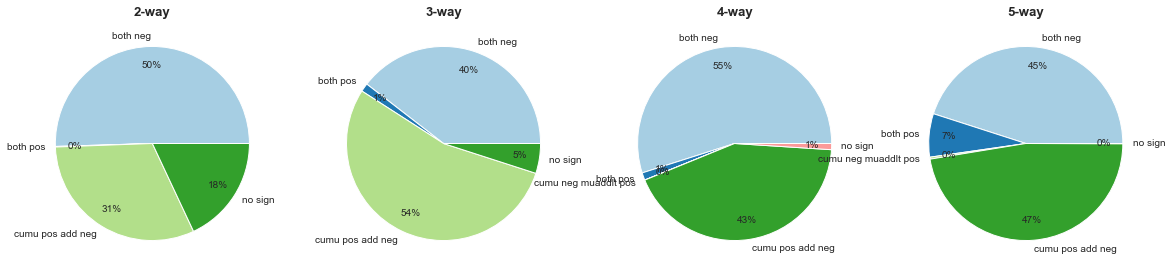

In [ ]:
def compute_sign_switches(df):
    iss = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    ad = np.array(concat_cols(df.filter(regex=(".*_ad"))))
    
    iss = iss[np.isfinite(ad)]
    ad = ad[np.isfinite(ad)]

    results = {}
    results['both pos'] = np.sum((iss > 0) & (ad > 1))
    results['both neg'] = np.sum((iss < 0) & (ad < 1))
    results['cumu pos add neg'] = np.sum((iss > 0) & (ad < 1))
    results['cumu neg muaddlt pos'] = np.sum((iss < 0) & (ad > 1))
    results['no sign'] = np.sum((iss == 0) | (ad == 1))

    total = np.sum([results[i] for i in sorted(results)])
    data = [results[i]/total for i in sorted(results) if results[i] > 0]
    labels = [i for i in sorted(results) if results[i] > 0]

    return data, labels


def plot_pie(d, l, c, t, index):
    axs[index].pie(d, labels = l, colors = c, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 10})
    axs[index].set_title(t, fontweight="bold")

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
colors = sns.color_palette('Paired')[0:5]

data, labels = compute_sign_switches(df_doub)
plot_pie(data, labels, colors, "2-way", 0)

data, labels = compute_sign_switches(df_trip)
plot_pie(data, labels, colors, "3-way", 1)

data, labels = compute_sign_switches(df_quad)
plot_pie(data, labels, colors, "4-way", 2)

data, labels = compute_sign_switches(df_quin)
plot_pie(data, labels, colors, "5-way", 3)



<Figure size 432x1440 with 0 Axes>

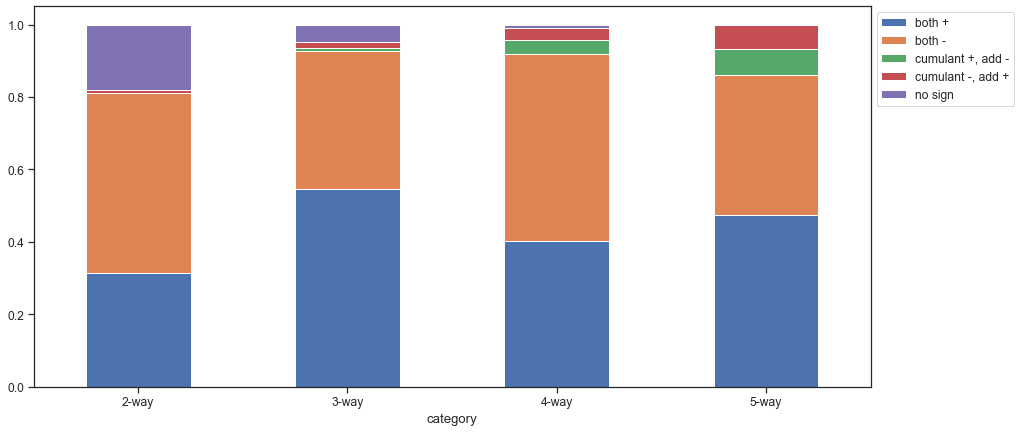

<Figure size 432x1440 with 0 Axes>

In [ ]:
def compute_sign_switches(df, category):
    iss = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    ad = np.array(concat_cols(df.filter(regex=(".*_ad"))))
    
    iss = iss[np.isfinite(ad)]
    ad = ad[np.isfinite(ad)]

    results = defaultdict(list)
    """results['category'].append('both +')
    results['number'].append( np.sum((iss > 0) & (mult > 1)) )

    results['category'].append('both -')
    results['number'].append( np.sum((iss < 0) & (mult < 1)) )

    results['category'].append('cumulant +, multiplicative -')
    results['number'].append( np.sum((iss > 0) & (mult < 1)) )

    results['category'].append('cumulant -, multiplicative +')
    results['number'].append( np.sum((iss < 0) & (mult > 1)) )

    results['category'].append('no sign')
    results['number'].append( np.sum((iss == 0) | (mult == 1)) )"""

    results['both +'].append(np.sum((iss > 0) & (ad > 0)))
    results['both -'].append(np.sum((iss < 0) & (ad < 0)))
    results['cumulant +, add -'].append(np.sum((iss > 0) & (ad < 0)))
    results['cumulant -, add +'].append(np.sum((iss < 0) & (ad > 0)))
    results['no sign'].append(np.sum((iss == 0) | (ad == 0)))

    #total = np.sum([i for i in results['number']])
    total = np.sum([results[i] for i in results])

    #results['fraction'] = [i/total for i in results['number']]
    
    for i in results:
        #results[i].append(results[i][0]/total)
        results[i][0] = results[i][0]/total
    results['category'].append(category)

    #print(results)

    df = pd.DataFrame.from_dict(results)
    return df



data = compute_sign_switches(df_doub, "2-way")
data = pd.concat([data, compute_sign_switches(df_trip, "3-way")], axis=0)
data = pd.concat([data, compute_sign_switches(df_quad, "4-way")], axis=0)
data = pd.concat([data, compute_sign_switches(df_quin, "5-way")], axis=0)

data = data.reset_index(drop=True)
pl = data.set_index('category').plot(kind='bar', stacked=True, figsize=(15,7), rot=0)
sns.move_legend(pl, "upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(6,20))



In [ ]:
data, labels = compute_sign_switches(df_doub)

data

TypeError: compute_sign_switches() missing 1 required positional argument: 'category'

higher order columns names
Index(['X1X2X3X4', 'X1X2X3X5', 'X1X2X4X5', 'X1X3X4X5', 'X2X3X4X5'], dtype='object')
lower order column names
Index(['X1X2X3', 'X1X2X4', 'X1X2X5', 'X1X3X4', 'X1X3X5', 'X1X4X5', 'X2X3X4',
       'X2X3X5', 'X2X4X5', 'X3X4X5'],
      dtype='object')
higher_order_degree:  4 lower_order_degree:  3
higher order col:  X1X2X3X4 combo of lower order cols:  ['X1X2X3', 'X1X2X4', 'X1X3X4', 'X2X3X4']
higher order col:  X1X2X3X5 combo of lower order cols:  ['X1X2X3', 'X1X2X5', 'X1X3X5', 'X2X3X5']
higher order col:  X1X2X4X5 combo of lower order cols:  ['X1X2X4', 'X1X2X5', 'X1X4X5', 'X2X4X5']
higher order col:  X1X3X4X5 combo of lower order cols:  ['X1X3X4', 'X1X3X5', 'X1X4X5', 'X3X4X5']
higher order col:  X2X3X4X5 combo of lower order cols:  ['X2X3X4', 'X2X3X5', 'X2X4X5', 'X3X4X5']
[ True  True  True ...  True  True  True]
finites:  168000
higher order columns names
Index(['X1X2X3X4', 'X1X2X3X5', 'X1X2X4X5', 'X1X3X4X5', 'X2X3X4X5'], dtype='object')
lower order column names


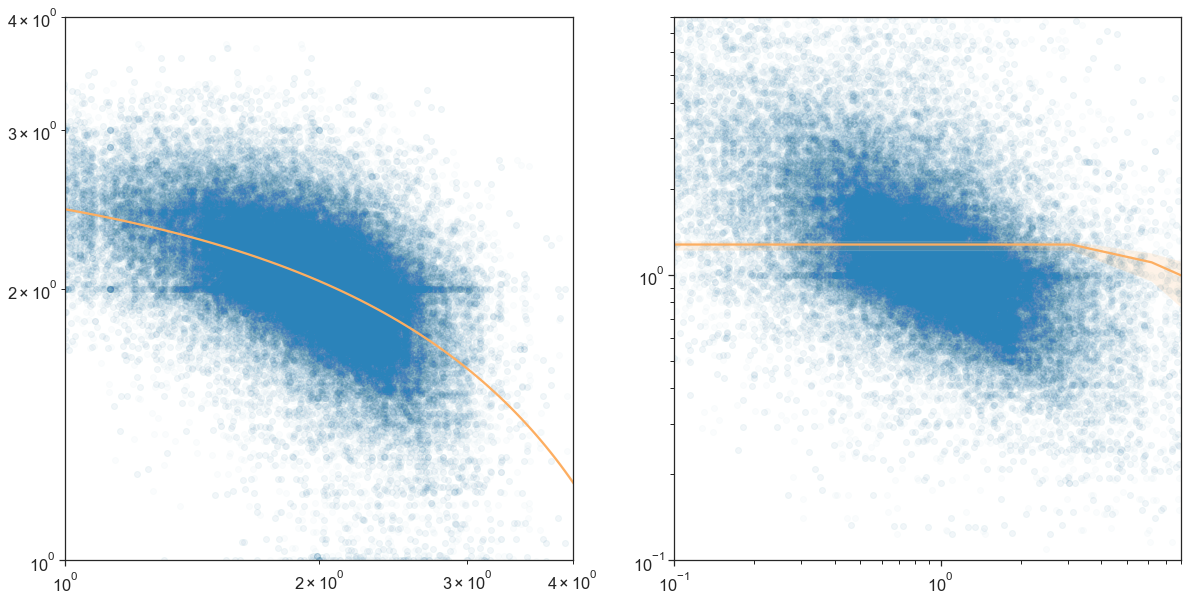

In [ ]:
def func(df_higher_order, df_lower_order, suff):
    df1 = df_higher_order.filter(regex=(f".*{suff}"))
    df2 = df_lower_order.filter(regex=(f".*{suff}"))
    df1.columns = df1.columns.str.rstrip(suff)
    df2.columns = df2.columns.str.rstrip(suff)

    print("higher order columns names")
    print(df1.columns)
    print("lower order column names")
    print(df2.columns)

    higher_order_degree = int(len(df1.columns[0])/2)
    lower_order_degree = int(len(df2.columns[0])/2)
    print("higher_order_degree: ", higher_order_degree, "lower_order_degree: ", lower_order_degree)

    # for each column of higher order interactions, find the lower oreder columns that consist of the lower order combinations
    # each row corresponds to a drug combination, so for each higher order interaction value (x values), find all the lower
    # order interactions (y values) from the same row
    x, y, = np.array([]), np.array([])
    for col in df1.columns:
        Xs = [col[i:i+2] for i in range(0, len(col), 2)]
        lower_order_cols = ["".join(list(i)) for i in list(itertools.combinations(Xs, lower_order_degree))]
        print("higher order col: ", col, "combo of lower order cols: ",  lower_order_cols)
        for i in lower_order_cols:
            x = np.append(x, list(df1[col]))
            y = np.append(y, list(df2[i]))
    
    finites = np.isfinite(y) & np.isfinite(x)
    print(finites)
    print("finites: ", np.sum(finites))
    x = x[finites]
    y = y[finites]
    return x, y

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

x_iss, y_iss = func(df_quad, df_trip, "_iss")
x_mult, y_mult = func(df_quad, df_trip, "_mult")
sns.regplot(x=x_iss+2, 
            y=y_iss+2,   
            scatter_kws={'alpha':0.02, 'color': for_plt['col_mult']},
            line_kws={'color': for_plt['col_iss']},
            ax = axs[0])
axs[0].set_xlim(1,4)
axs[0].set_ylim(1,4)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
sns.regplot(x=x_mult, 
            y=y_mult,   
            scatter_kws={'alpha':0.02, 'color': for_plt['col_mult']},
            line_kws={'color': for_plt['col_iss']},
            ax = axs[1])
axs[1].set_xlim(0.1,8)
axs[1].set_ylim(0.1,8)
axs[1].set_xscale('log')
axs[1].set_yscale('log')


In [ ]:
print(pd.DataFrame(list(zip(x_iss, y_iss)), columns=["x", "y"]).corr(method="pearson"))
print(pd.DataFrame(list(zip(np.log(x_mult), np.log(y_mult))), columns=["x", "y"]).corr(method="pearson"))

          x         y
x  1.000000 -0.595602
y -0.595602  1.000000
          x         y
x  1.000000 -0.546771
y -0.546771  1.000000


<ipython-input-17-46cf5f6e1bec>:2: RuntimeWarning: divide by zero encountered in log
  print(pd.DataFrame(list(zip(np.log(x_mult), np.log(y_mult))), columns=["x", "y"]).corr(method="pearson"))


(-0.1, 7.0)

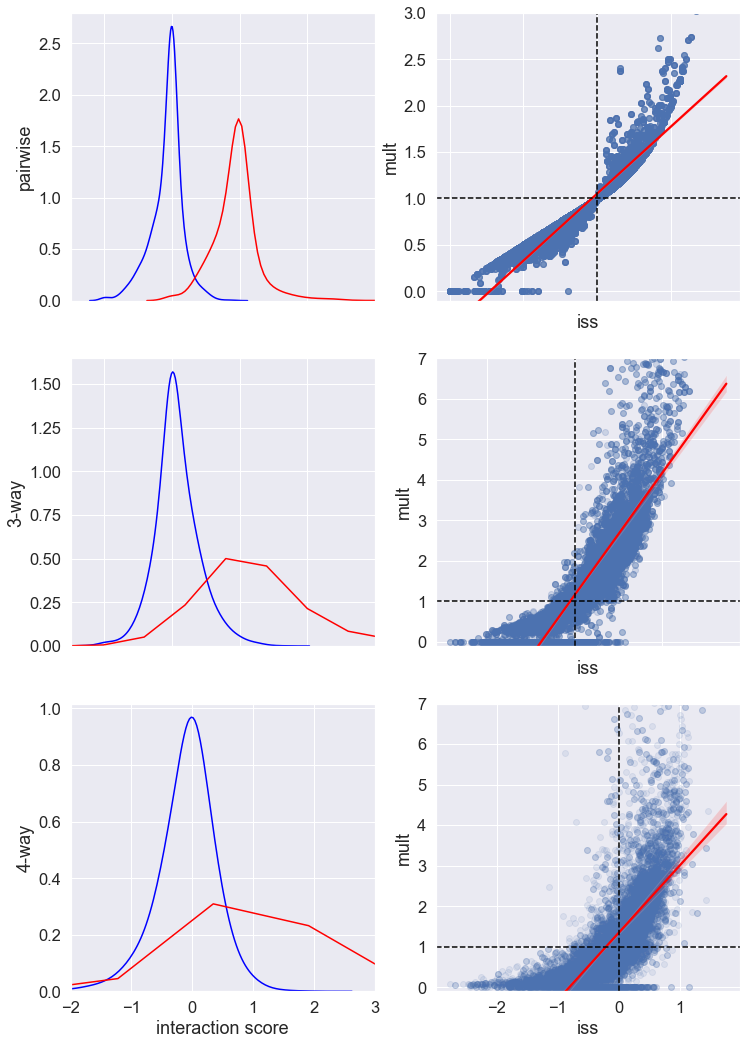

In [ ]:
# KDE plots look like shit


def get_noninf(df):
    x = np.array(concat_cols(df.filter(regex=(".*_iss"))))
    y = np.array(concat_cols(df.filter(regex=(".*_mult"))))
    return x[np.isfinite(y)], y[np.isfinite(y)]

sns.set(font_scale = 1.5)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,5))
fig.set_size_inches(12, 18)
bins=20
bw=3
transparency=0.1

##################
sns.kdeplot(concat_cols(df_doub.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[0,0])
sns.kdeplot(concat_cols(df_doub.filter(regex=(".*_mult"))),  color="red", bw_adjust=bw, ax=axs[0,0])
axs[0,0].set(xlabel=None, ylabel="pairwise", xticklabels=[])
axs[0,0].set_xlim(-1.5,3)

x, y = get_noninf(df_doub)
sns.regplot(x=x, 
            y=y,   
            scatter_kws={'alpha':transparency},
            line_kws={'color': 'red'},
            ax=axs[0,1])
axs[0,1].set(xlabel="iss", ylabel="mult", xticklabels=[])
axs[0,1].axvline(0, color="black", linestyle="--")
axs[0,1].axhline(1, color="black", linestyle="--")
axs[0,1].set_ylim(-0.1,3)

##################
sns.kdeplot(concat_cols(df_trip.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[1,0])
sns.kdeplot(concat_cols(df_trip.filter(regex=(".*_mult"))),  color="red", bw_adjust=bw, ax=axs[1,0])
axs[1,0].set(xlabel=None, ylabel="3-way", xticklabels=[])
axs[1,0].set_xlim(-1.5,3)


x, y = get_noninf(df_trip)
sns.regplot(x=x, 
            y=y,  
            scatter_kws={'alpha':transparency},
            line_kws={'color': 'red'},
            ax=axs[1,1])
axs[1,1].set(xlabel="iss", ylabel="mult", xticklabels=[])
axs[1,1].axvline(0, color="black", linestyle="--")
axs[1,1].axhline(1, color="black", linestyle="--")
axs[1,1].set_ylim(-0.1,7)

##################
sns.kdeplot(concat_cols(df_quad.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[2,0])
sns.kdeplot(concat_cols(df_quad.filter(regex=(".*_mult"))),  color="red", bw_adjust=bw, ax=axs[2,0])
axs[2,0].set(xlabel="interaction score", ylabel="4-way")
axs[2,0].set_xlim(-2,3)

x, y = get_noninf(df_quad)
sns.regplot(x=x,
            y=y,  
            scatter_kws={'alpha':transparency},
            line_kws={'color': 'red'},
            ax=axs[2,1])
axs[2,1].set(xlabel="iss", ylabel="add")
axs[2,1].axvline(0, color="black", linestyle="--")
axs[2,1].axhline(1, color="black", linestyle="--")
axs[2,1].set_ylim(-0.1,7)


In [ ]:
theta=0.001
watt_denom = (1 + 1/2)
genome_size= 3.298912062*(10**9)
S = theta*watt_denom*genome_size
print(S)

4948368.093


In [ ]:
binom(8,5)

56.0

In [ ]:
468+810+195+810+770+150+35

3238